# Titanic (lightGBM classifier)
* Notebook: 
* kaggle: https://www.kaggle.com/c/titanic
* lightgbm: https://lightgbm.readthedocs.io/en/latest/

[<img src="https://github.com/microsoft/LightGBM/raw/master/docs/logo/LightGBM_logo_black_text_small.png">](https://lightgbm.readthedocs.io/en/latest/)

---
* author:  [Prasert Kanawattanachai](prasert.k@chula.ac.th)
* YouTube: https://www.youtube.com/prasertcbs
* github: https://github.com/prasertcbs/
* [Chulalongkorn Business School](https://www.cbs.chula.ac.th/en/)
---

In [1]:
import math
from pprint import pprint
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
print(f'pandas  version: {pd.__version__}')
print(f'numpy   version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

pandas  version: 1.2.3
numpy   version: 1.19.2
seaborn version: 0.11.1


## utility functions

In [4]:
def df_unique_value(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            print(f'{c:10}\n{df[c].unique()}')
            print('-' * 65)
            
def convert_cols_to_category(df, cols:list):
    """
    convert `cols` to `category`
    """
    for c in df[cols]:
        df[c] = df[c].astype('category')
    return df
    
def convert_obj_columns_to_category(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            df[c] = df[c].astype('category')
    return df

def print_category_columns(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type.name == 'category':
    #         print(f'{c}: {df[c].cat.categories}')
    #         print(pd.Series(df[c].cat.categories))
            print(f'{c:15}: {list(enumerate(df[c].cat.categories))}')
            print('-' * 60)
            
def plot_mn(df, cols, n_rows:int=1, kind:str='boxplot', color='salmon'):
    """
    plot boxplot, violin, hist in m (rows) by n (columns)
    >>> plot_mn(df, ['Calories', 'Fat'], 2, 'hist')
    """
    n=len(cols)
    n_cols=math.ceil(n / n_rows)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*4))
    ax=ax.ravel()

    fig.tight_layout()
    for i, c in enumerate(cols):
        col_type = df[c].dtype
        if col_type.name == 'category':
            sns.countplot(data=df, x=c, ax=ax[i])
        else:
            if kind.lower()=='boxplot':
                sns.boxplot(data=df[[c]], ax=ax[i], color=color)   
            elif kind.lower()=='violin':
                sns.violinplot(data=df[[c]], ax=ax[i], color=color)   
            elif kind.lower()=='hist':
                sns.distplot(df[c], hist=True, kde=False, ax=ax[i], color=color)  


## data
| Variable | Definition                                                             | Key                                            |
|----------|------------------------------------------------------------------------|------------------------------------------------|
| Survived | Survival                                                               | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                                                           | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                                                    |                                                |
| Age      | Age in years                                                           |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic                             |                                                |
|          | Sibling = brother, sister, stepbrother, stepsister                     |                                                |
|          | Spouse = husband, wife (mistresses and fiancés were ignored)           |                                                |
| Parch    | # of parents / children aboard the Titanic                             |                                                |
|          | Parent = mother, father                                                |                                                |
|          | Child = daughter, son, stepdaughter, stepson                           |                                                |
|          | Some children travelled only with a nanny, therefore parch=0 for them. |                                                |
| Ticket   | Ticket number                                                          |                                                |
| Fare     | Passenger fare                                                         |                                                |
| Cabin    | Cabin number                                                           |                                                |
| Embarked | Port of Embarkation                                                    | C = Cherbourg, Q = Queenstown, S = Southampton |

In [5]:
df=pd.read_csv('https://github.com/prasertcbs/basic-dataset/raw/master/titanic_train.csv')
df.sample(n=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
566,567,0,3,"Stoytcheff, Mr. Ilia",male,19.0,0,0,349205,7.8958,NaN,S
819,820,0,3,"Skoog, Master. Karl Thorsten",male,10.0,3,2,347088,27.9000,NaN,S
777,778,1,3,"Emanuel, Miss. Virginia Ethel",female,5.0,0,0,364516,12.4750,NaN,S
386,387,0,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9000,NaN,S
198,199,1,3,"Madigan, Miss. Margaret ""Maggie""",female,NaN,0,0,370370,7.7500,NaN,Q
744,745,1,3,"Stranden, Mr. Juho",male,31.0,0,0,STON/O 2. 3101288,7.9250,NaN,S
726,727,1,2,"Renouf, Mrs. Peter Henry (Lillian Jefferys)",female,30.0,3,0,31027,21.0000,NaN,S
467,468,0,1,"Smart, Mr. John Montgomery",male,56.0,0,0,113792,26.5500,NaN,S
60,61,0,3,"Sirayanian, Mr. Orsen",male,22.0,0,0,2669,7.2292,NaN,C
525,526,0,3,"Farrell, Mr. James",male,40.5,0,0,367232,7.7500,NaN,Q


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### convert obj/string columns to category data type for lightGBM

In [7]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [8]:
cols_to_cat=['Pclass', 'Sex', 'Embarked']

convert_cols_to_category(df, cols_to_cat)
print_category_columns(df)

Pclass         : [(0, 1), (1, 2), (2, 3)]
------------------------------------------------------------
Sex            : [(0, 'female'), (1, 'male')]
------------------------------------------------------------
Embarked       : [(0, 'C'), (1, 'Q'), (2, 'S')]
------------------------------------------------------------


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    category
dtypes: category(3), float64(2), int64(4), object(3)
memory usage: 65.8+ KB


In [10]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

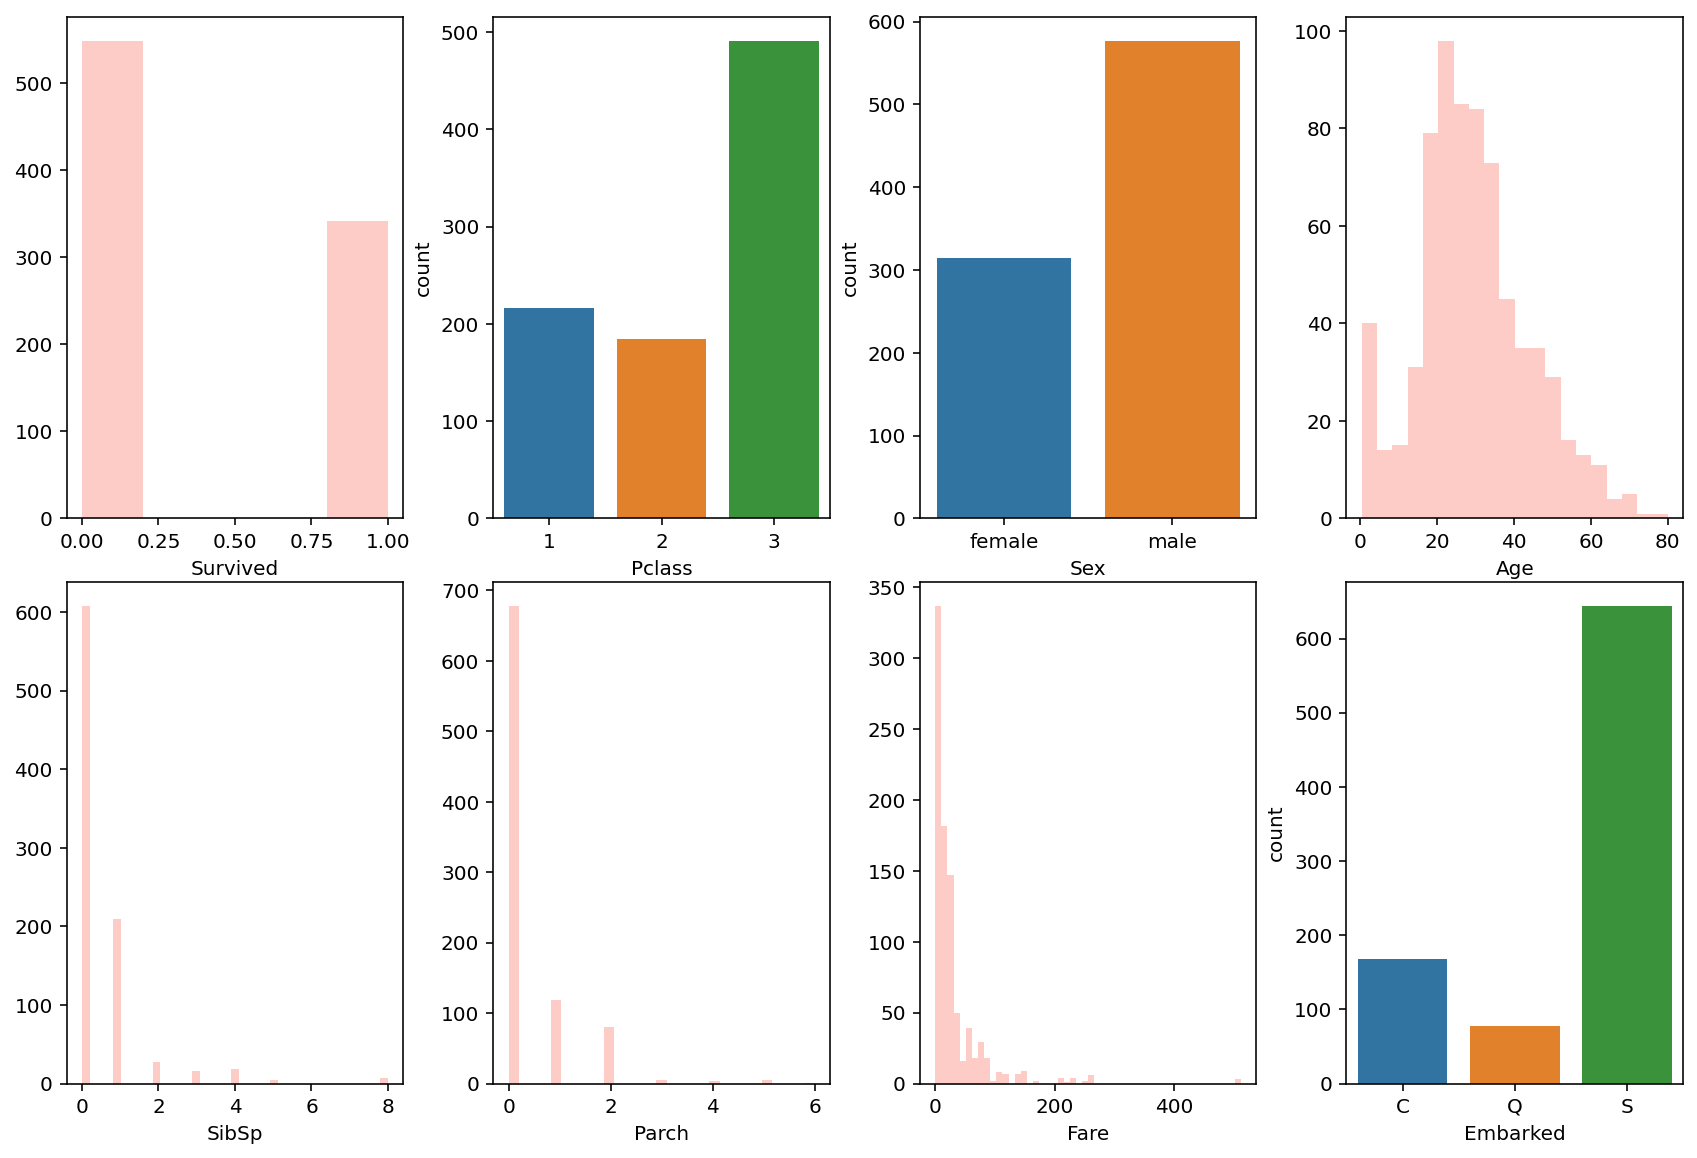

In [11]:
cols=['Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked']
plot_mn(df, cols, 2, 'hist')

## lightgbm
* `lightGBM` doc: https://lightgbm.readthedocs.io/en/latest/
* `LGBMClassifier`: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier


how to install lightgbm
* pip: `pip install -U lightgbm`
* conda: `conda install lightgbm`

In [12]:
import lightgbm as lgb
print(f'lightgbm version {lgb.__version__}')

lightgbm version 3.1.1


In [13]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, ShuffleSplit, cross_val_score, cross_val_predict, cross_validate
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, precision_recall_fscore_support, f1_score

In [14]:
df[:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [16]:
feature_cols=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']
target_col='Survived'

X=df[feature_cols]
y=df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=1, 
                                                    stratify=y)

In [17]:
y_train.value_counts()

0    439
1    273
Name: Survived, dtype: int64

In [18]:
clf=lgb.LGBMClassifier()

In [19]:
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [20]:
# tuning parameters: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
# https://sites.google.com/view/lauraepp/parameters
params={'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

# clf = lgb.LGBMClassifier(**params)

In [21]:
# eval_metric: https://lightgbm.readthedocs.io/en/latest/Parameters.html?highlight=metric#metric-parameters
fit_params={'early_stopping_rounds':100, 
            'eval_metric': 'auc', # [binary_logloss, auc]
            'eval_set': [(X_test, y_test)],
            'verbose': 10
           }

clf.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.861001	valid_0's binary_logloss: 0.462338
[20]	valid_0's auc: 0.86996	valid_0's binary_logloss: 0.419414
[30]	valid_0's auc: 0.868709	valid_0's binary_logloss: 0.409488
[40]	valid_0's auc: 0.869829	valid_0's binary_logloss: 0.410124
[50]	valid_0's auc: 0.866601	valid_0's binary_logloss: 0.415623
[60]	valid_0's auc: 0.863175	valid_0's binary_logloss: 0.421308
[70]	valid_0's auc: 0.855995	valid_0's binary_logloss: 0.425925
[80]	valid_0's auc: 0.855731	valid_0's binary_logloss: 0.429418
[90]	valid_0's auc: 0.854677	valid_0's binary_logloss: 0.434468
[100]	valid_0's auc: 0.854414	valid_0's binary_logloss: 0.436328
Did not meet early stopping. Best iteration is:
[35]	valid_0's auc: 0.874111	valid_0's binary_logloss: 0.407121


LGBMClassifier()

In [22]:
clf.__dict__

{'boosting_type': 'gbdt',
 'objective': None,
 'num_leaves': 31,
 'max_depth': -1,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'subsample_for_bin': 200000,
 'min_split_gain': 0.0,
 'min_child_weight': 0.001,
 'min_child_samples': 20,
 'subsample': 1.0,
 'subsample_freq': 0,
 'colsample_bytree': 1.0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'random_state': None,
 'n_jobs': -1,
 'silent': True,
 'importance_type': 'split',
 '_Booster': <lightgbm.basic.Booster at 0x1618d33d848>,
 '_evals_result': {'valid_0': OrderedDict([('auc',
                [0.8640316205533597,
                 0.8654150197628458,
                 0.8624505928853755,
                 0.8602766798418973,
                 0.8601449275362318,
                 0.8635046113306983,
                 0.8617918313570487,
                 0.8586297760210804,
                 0.8600790513833992,
                 0.8610013175230566,
                 0.8648221343873518,
                 0.8668642951251647,
                 0.8694

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

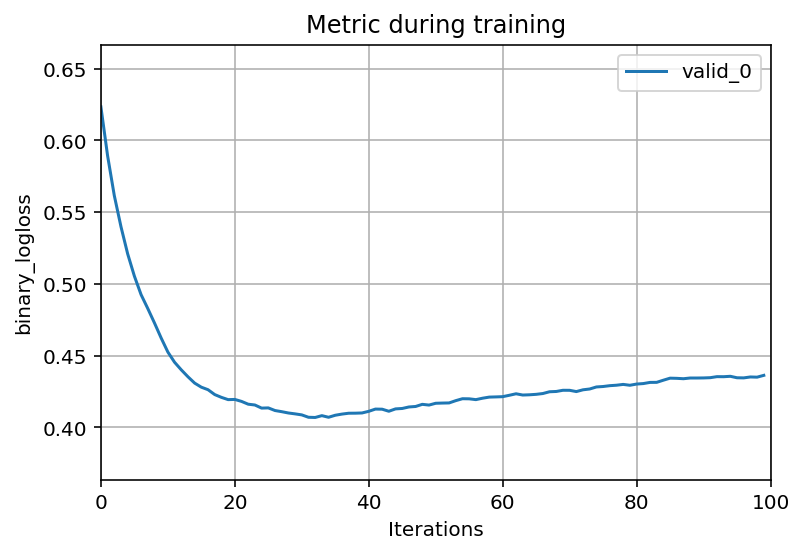

In [23]:
lgb.plot_metric(clf, metric='binary_logloss')

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='auc'>

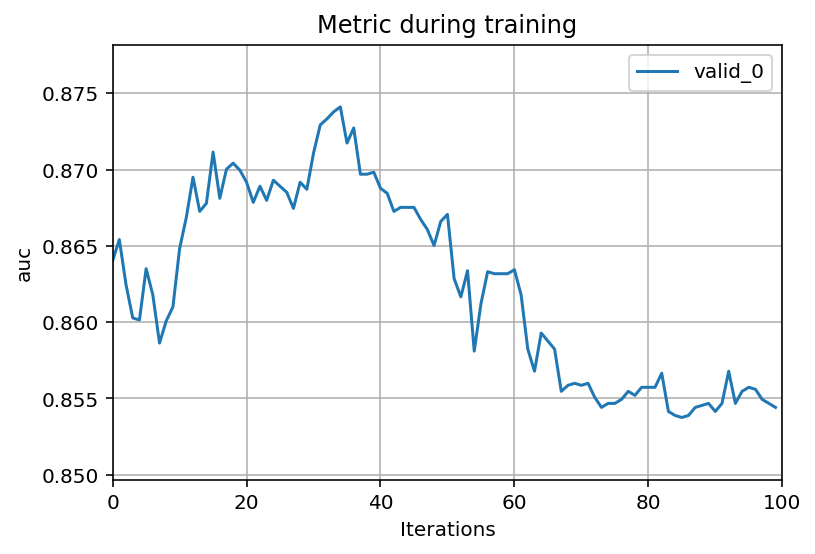

In [24]:
lgb.plot_metric(clf, metric='auc')

In [25]:
clf.score(X_train, y_train) # classification accuracy score

0.8665730337078652

In [26]:
clf.score(X_test, y_test) # classification accuracy score

0.8268156424581006

In [27]:
clf.predict(X_test)[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
      dtype=int64)

In [28]:
clf.predict_proba(X_test)[:20]

array([[0.91360286, 0.08639714],
       [0.79197245, 0.20802755],
       [0.80852233, 0.19147767],
       [0.95671841, 0.04328159],
       [0.87389583, 0.12610417],
       [0.91130764, 0.08869236],
       [0.84509911, 0.15490089],
       [0.76564625, 0.23435375],
       [0.95559406, 0.04440594],
       [0.83967771, 0.16032229],
       [0.08795388, 0.91204612],
       [0.76564625, 0.23435375],
       [0.68397793, 0.31602207],
       [0.91708487, 0.08291513],
       [0.03112827, 0.96887173],
       [0.71875991, 0.28124009],
       [0.90086911, 0.09913089],
       [0.16406639, 0.83593361],
       [0.46702718, 0.53297282],
       [0.95559406, 0.04440594]])

### confusion matrix
$$
\begin{bmatrix}
C_{0,0} & C_{0,1} \\
C_{1,0} & C_{1,1}
\end{bmatrix}
=
\begin{bmatrix}
tn&fp \\
fn&tp
\end{bmatrix}
$$

<table>
<tr>
    <td></td>
    <td>predicted false</td>
    <td>predicted true</td>
</tr>
<tr>
    <td>actual false</td>
    <td>tn</td>
    <td>fp</td>
</tr>
<tr>
    <td>actual true</td>
    <td>fn</td>
    <td>tp</td>
</tr>
<table>

In [29]:
cm=confusion_matrix(y_test, clf.predict(X_test))
cm

array([[97, 13],
       [18, 51]], dtype=int64)

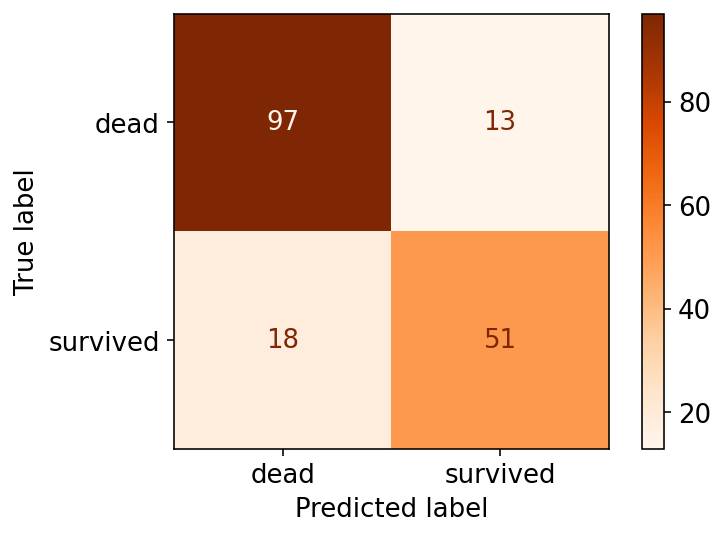

In [30]:
plt.rcParams['font.size']=13
plot_confusion_matrix(clf, X_test, y_test, cmap='Oranges', display_labels=['dead', 'survived'])

$$
\begin{align}
\text {Accuracy}&={\frac {{TP+TN} }{TP + TN +FP + FN} }\\
\text {Precision}&={\frac {TP}{TP+FP}}\\
\text {Recall, True Positive Rate (TPR), sensitivity}&={\frac {TP}{TP+FN}}\\
\text {False Positive Rate (FPR), miss rate}&={\frac {FP}{FP+TN}}\\
F1&=2 \times {\frac {precision \times recall} {precision + recall}}\\
\end{align}
$$

$$
\begin{align}
Recall_0&={\frac {TN}{TN+FP}}\\
Recall_1&={\frac {TP}{TP+FN}}\\
Precision_0&={\frac {TN}{TN+FN}}\\
Precision_1&={\frac {TP}{TP+FP}}\\
\end{align}
$$

In [31]:
print(classification_report(y_train, clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       439
           1       0.88      0.75      0.81       273

    accuracy                           0.87       712
   macro avg       0.87      0.85      0.85       712
weighted avg       0.87      0.87      0.86       712



In [32]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       110
           1       0.80      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179



In [33]:
# explore threshold
def precision(cfm):
    '''
    precision
    '''
    tn, fp, fn, tp = cfm.ravel()
    return tp / (tp + fp)

def tpr(cfm):
    '''
    true positive rate (recall)
    '''
    tn, fp, fn, tp = cfm.ravel()
    return tp / (tp + fn)

def fpr(cfm):
    '''
    false positive rate'''
    tn, fp, fn, tp = cfm.ravel()
    return fp / (fp + tn)

def cm(model, X, y, thres=.5):
    '''
    confusion matrix at a given threshold
    '''
    y_pred_tmp=np.where(model.predict_proba(X)[:, 1] >= thres, 1, 0)
    return confusion_matrix(y, y_pred_tmp)

def varying_threshold(model, X, y, thresholds=np.linspace(0.05, .95, 15)):
    for thres in thresholds:
        cfm=cm(model, X, y, thres)
        print(f'threshold={thres:.2f}, TPR = {tpr(cfm):.2f}, FPR = {fpr(cfm):.2f}, precision = {precision(cfm):.2f}');    
        print(cfm)
        print('-' * 100)
        
varying_threshold(clf, X_test, y_test)

threshold=0.05, TPR = 0.99, FPR = 0.94, precision = 0.40
[[  7 103]
 [  1  68]]
----------------------------------------------------------------------------------------------------
threshold=0.11, TPR = 0.91, FPR = 0.55, precision = 0.51
[[50 60]
 [ 6 63]]
----------------------------------------------------------------------------------------------------
threshold=0.18, TPR = 0.87, FPR = 0.40, precision = 0.58
[[66 44]
 [ 9 60]]
----------------------------------------------------------------------------------------------------
threshold=0.24, TPR = 0.87, FPR = 0.27, precision = 0.67
[[80 30]
 [ 9 60]]
----------------------------------------------------------------------------------------------------
threshold=0.31, TPR = 0.80, FPR = 0.19, precision = 0.72
[[89 21]
 [14 55]]
----------------------------------------------------------------------------------------------------
threshold=0.37, TPR = 0.77, FPR = 0.14, precision = 0.78
[[95 15]
 [16 53]]
-----------------------------------

### cross validation

In [34]:
scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(scores)
print(f'mean scores = {scores.mean()}, sd={scores.std():.4f}')                                              

[0.83798883 0.82022472 0.81460674 0.8258427  0.84269663]
mean scores = 0.8282719226664993, sd=0.0106


### feature importances

In [35]:
clf.feature_importances_

array([116,  37, 537,  82,  43])

In [36]:
X.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch'], dtype='object')

In [37]:
feature_importances=pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances

Age       537
Pclass    116
SibSp      82
Parch      43
Sex        37
dtype: int32

In [38]:
pd.DataFrame(feature_importances).style.background_gradient(cmap="Oranges")

,0
Age,537
Pclass,116
SibSp,82
Parch,43
Sex,37


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

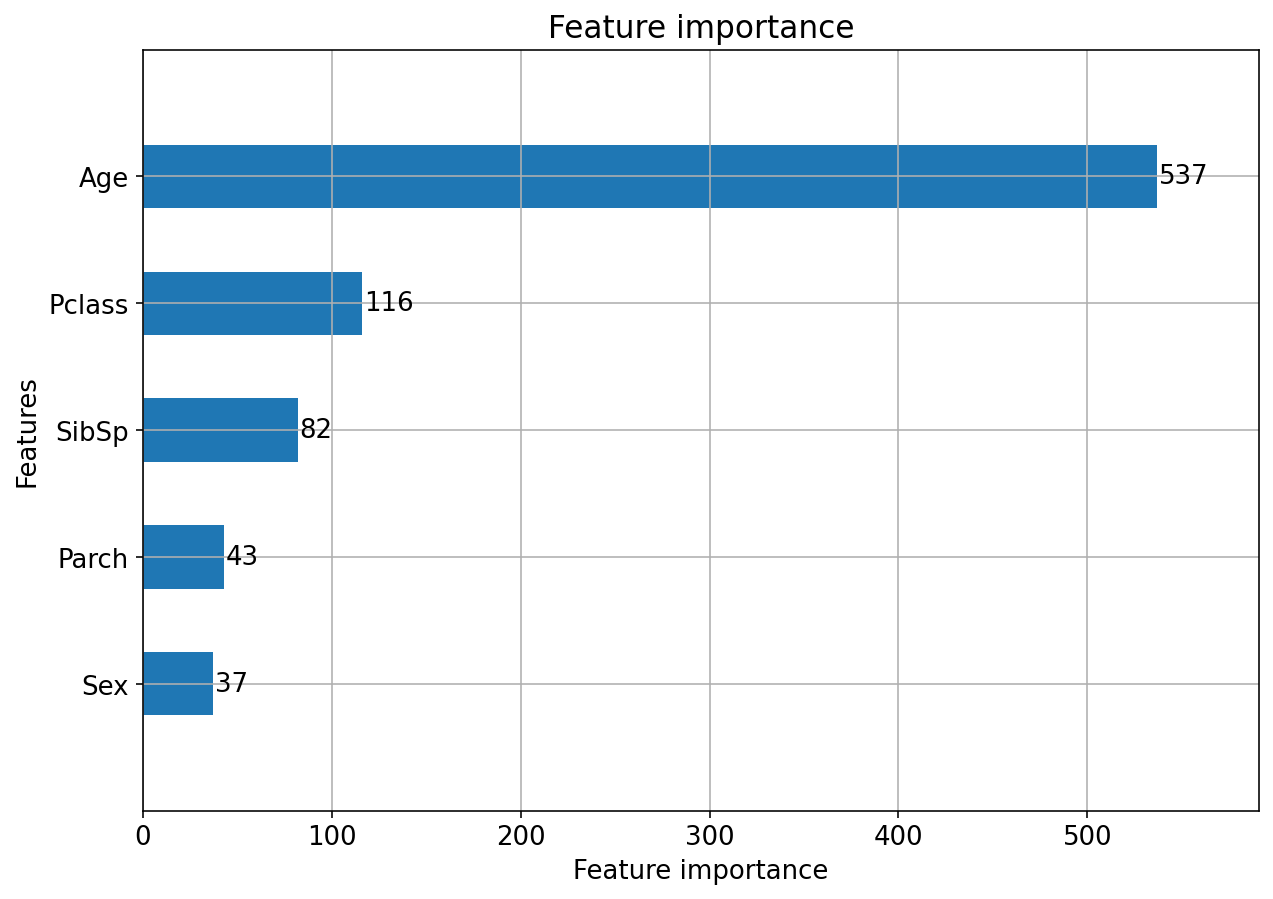

In [39]:
lgb.plot_importance(clf, figsize=(10, 7), height=.5)

### tree diagram
* **install graphviz on Windows**
1. install graphviz: `pip install -U graphviz`
1. download graphviz: https://www2.graphviz.org/Packages/stable/windows/10/msbuild/Release/Win32/
1. extract and copy to: `C:\Program Files (x86)\Graphviz\bin`
1. add `C:\Program Files (x86)\Graphviz\bin` to `PATH` enviroment variable

In [40]:
print_category_columns(df)

Pclass         : [(0, 1), (1, 2), (2, 3)]
------------------------------------------------------------
Sex            : [(0, 'female'), (1, 'male')]
------------------------------------------------------------
Embarked       : [(0, 'C'), (1, 'Q'), (2, 'S')]
------------------------------------------------------------


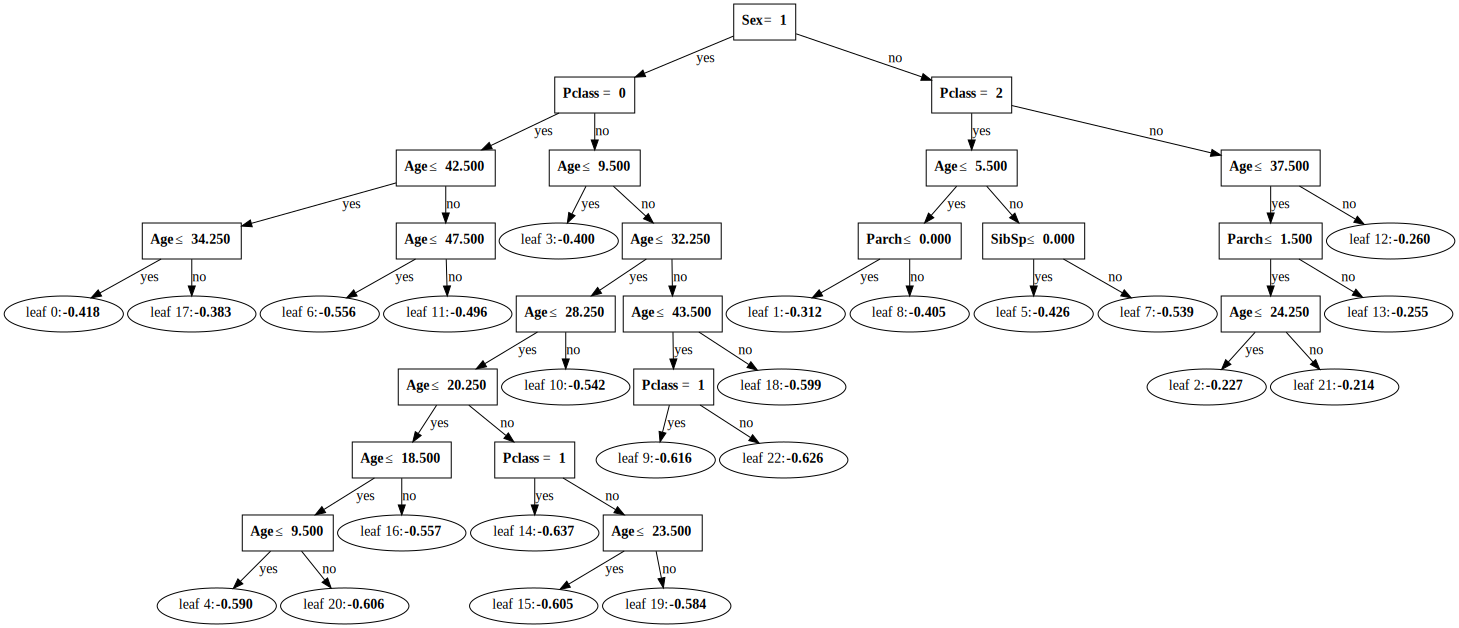

In [41]:
lgb.create_tree_digraph(clf, orientation='vertical')

In [42]:
# show_info=['split_gain', 'leaf_count', 'leaf_weight', 'internal_value', 'data_percentage']
show_info=['leaf_weight', 'internal_value', 'data_percentage']
orientation='horizontal'

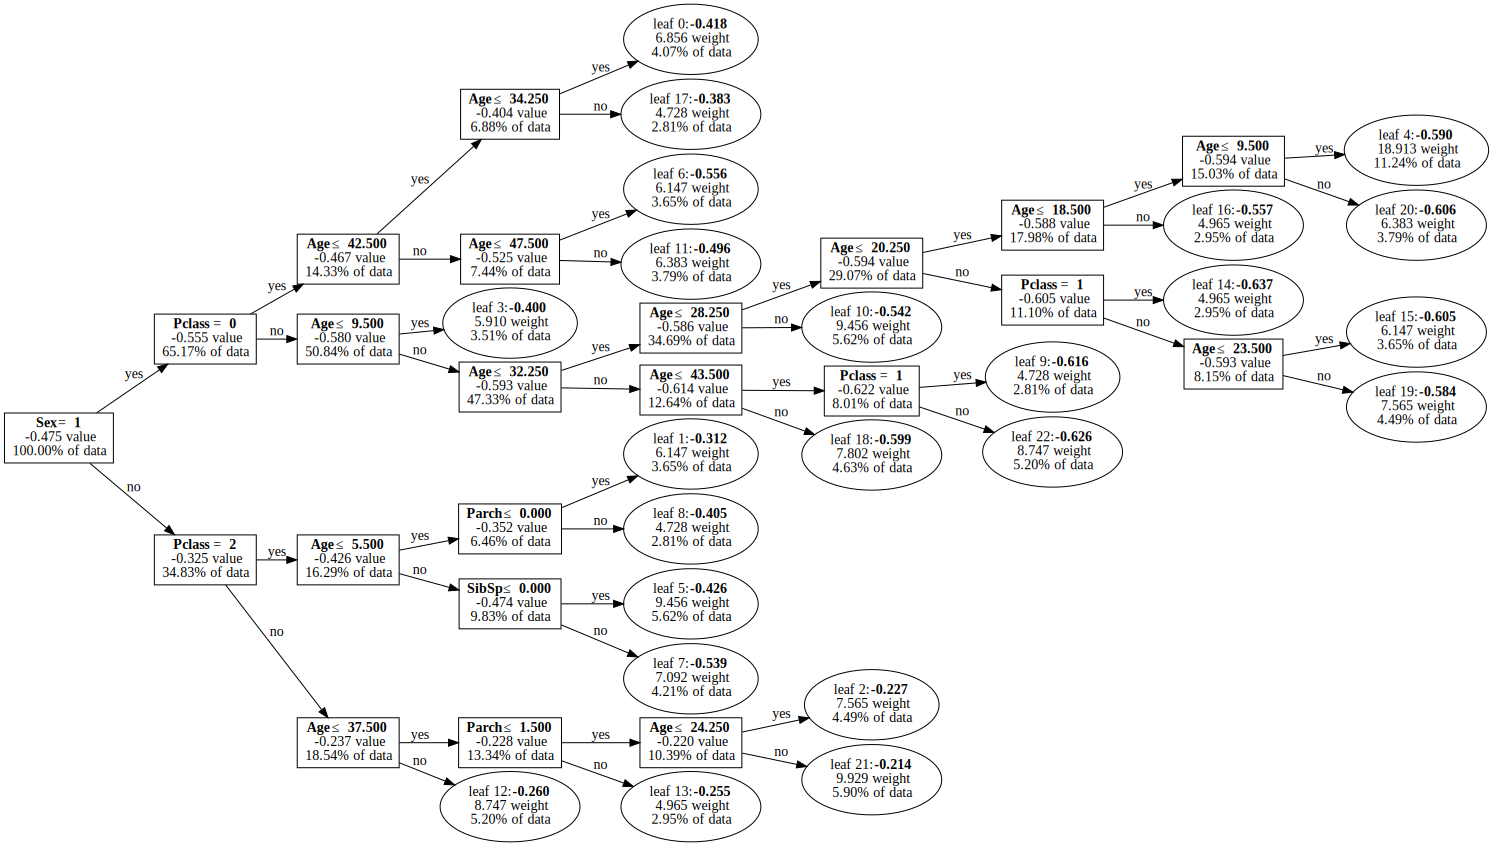

In [43]:
lgb.create_tree_digraph(clf, orientation=orientation, show_info=show_info)

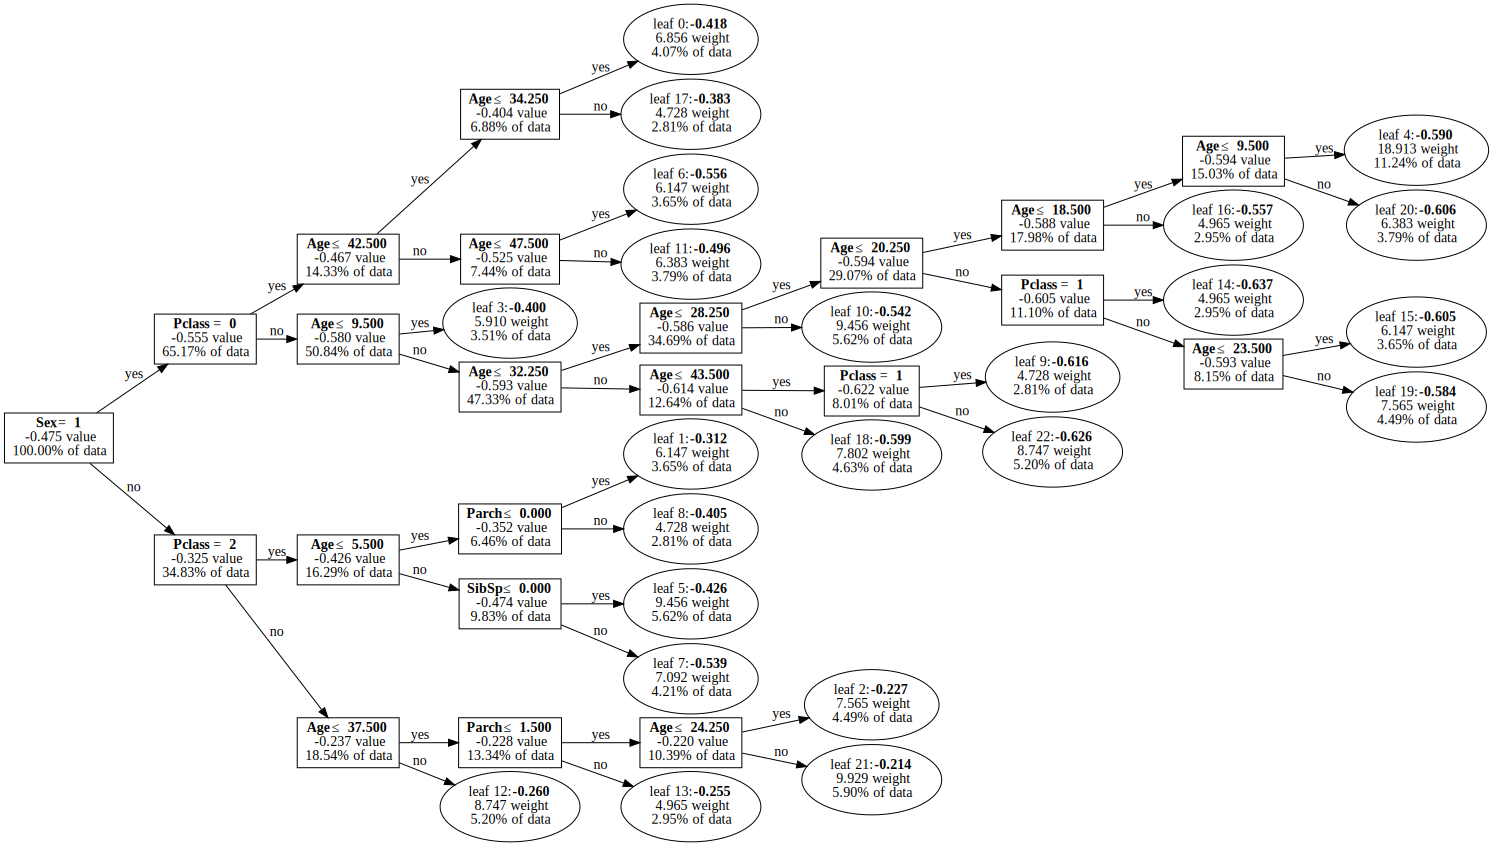

In [44]:
lgb.create_tree_digraph(clf, orientation=orientation, tree_index=0, show_info=show_info)

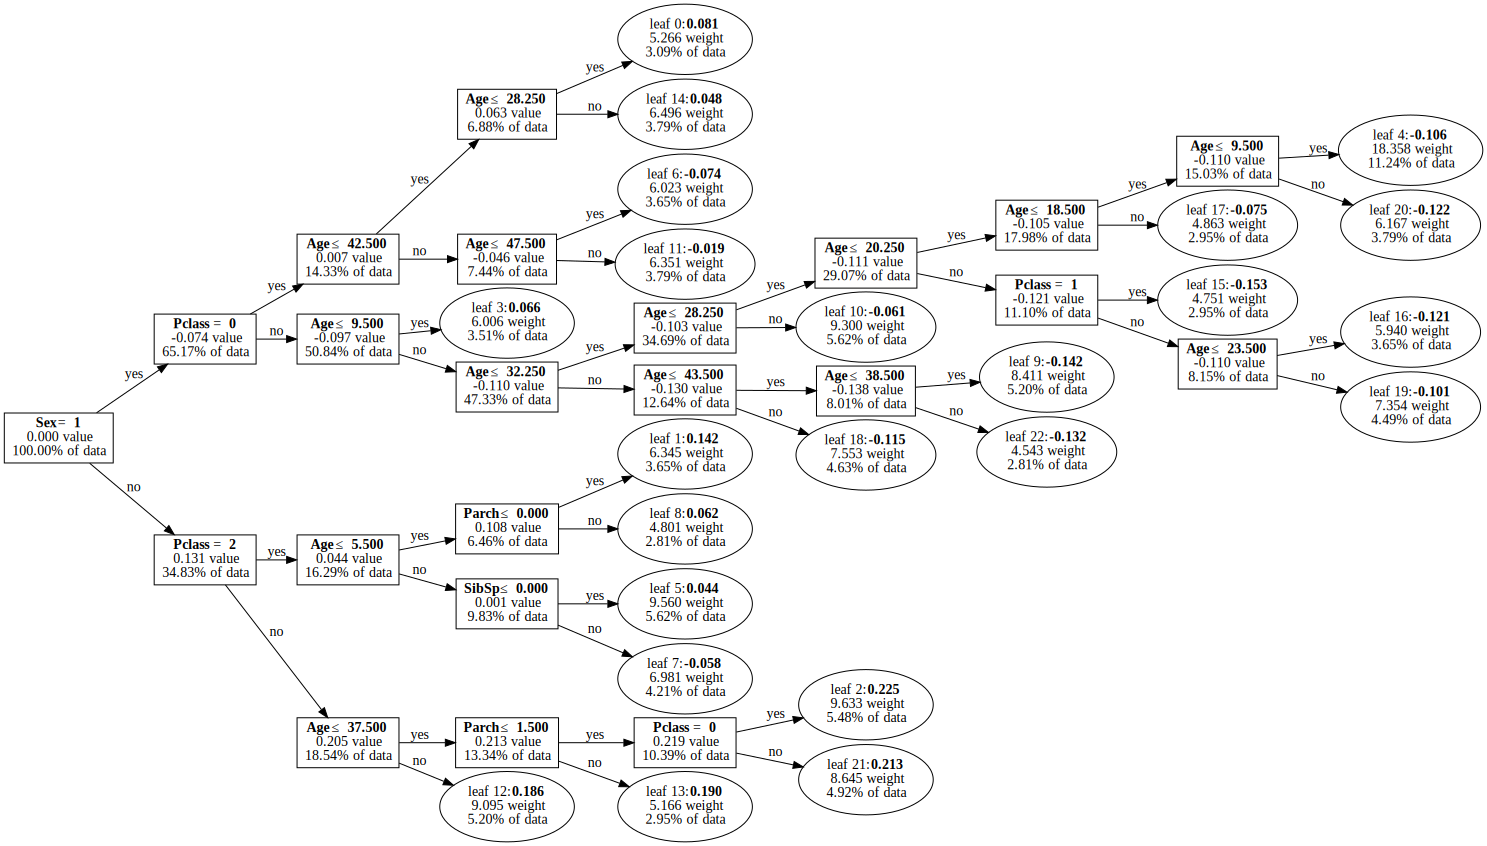

In [45]:
lgb.create_tree_digraph(clf, orientation=orientation, tree_index=1, show_info=show_info)

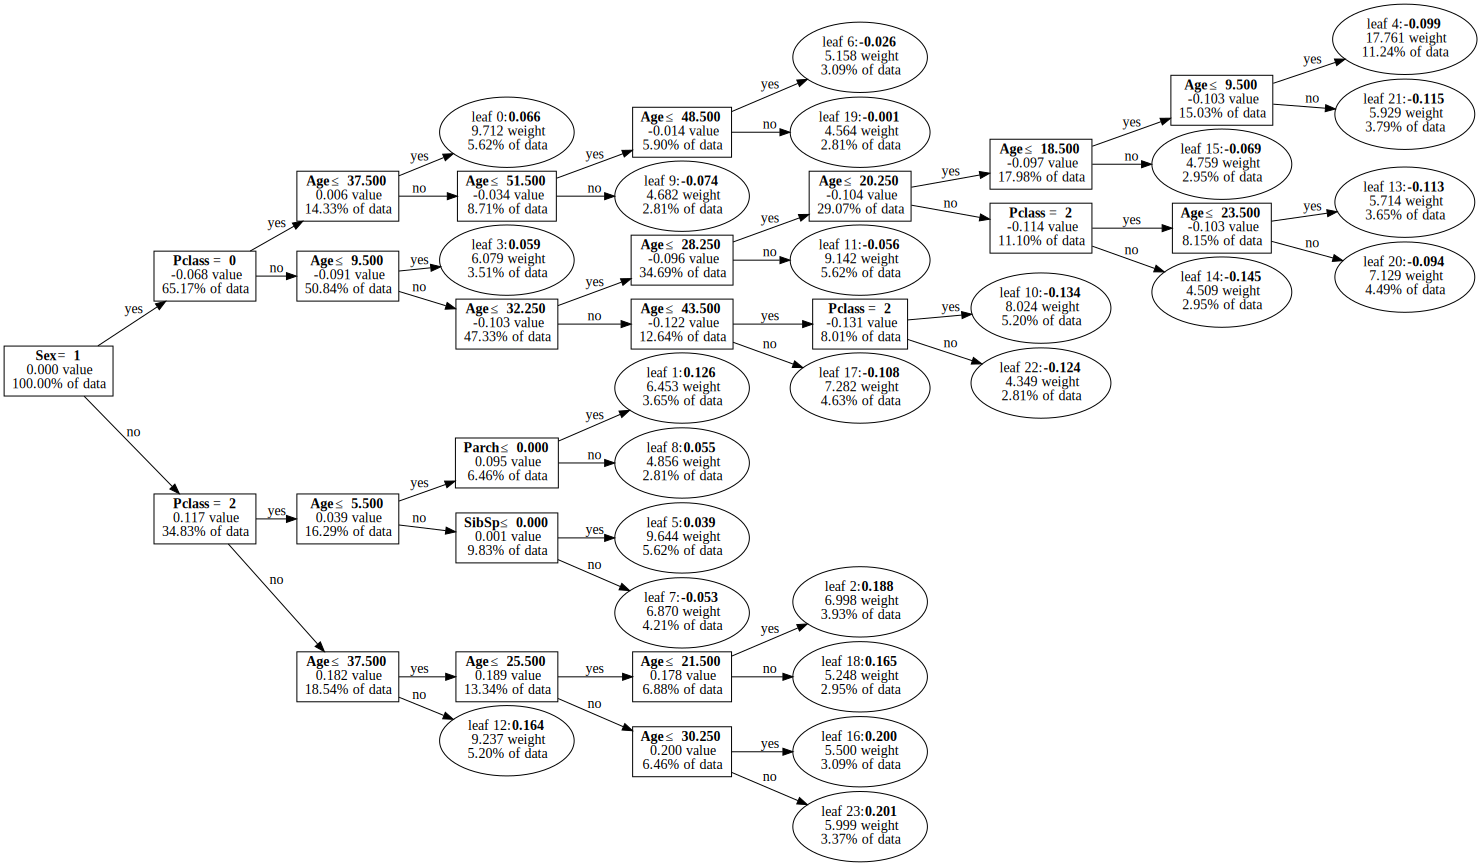

In [46]:
lgb.create_tree_digraph(clf, orientation=orientation, tree_index=2, show_info=show_info)

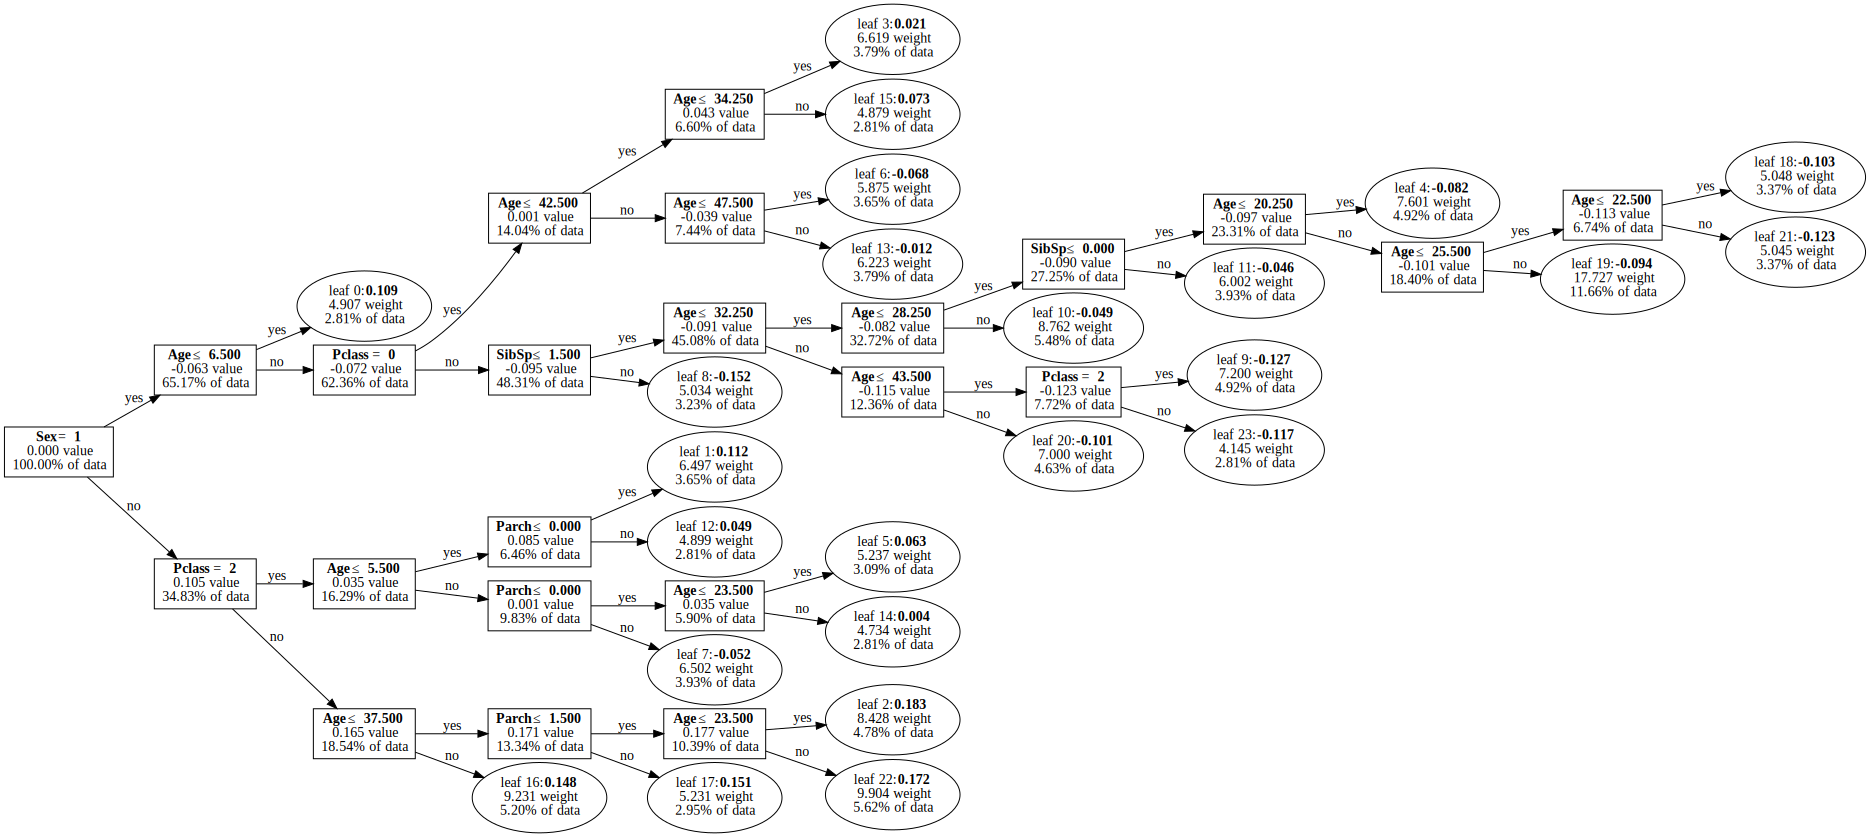

In [47]:
lgb.create_tree_digraph(clf, orientation=orientation, tree_index=3, show_info=show_info)

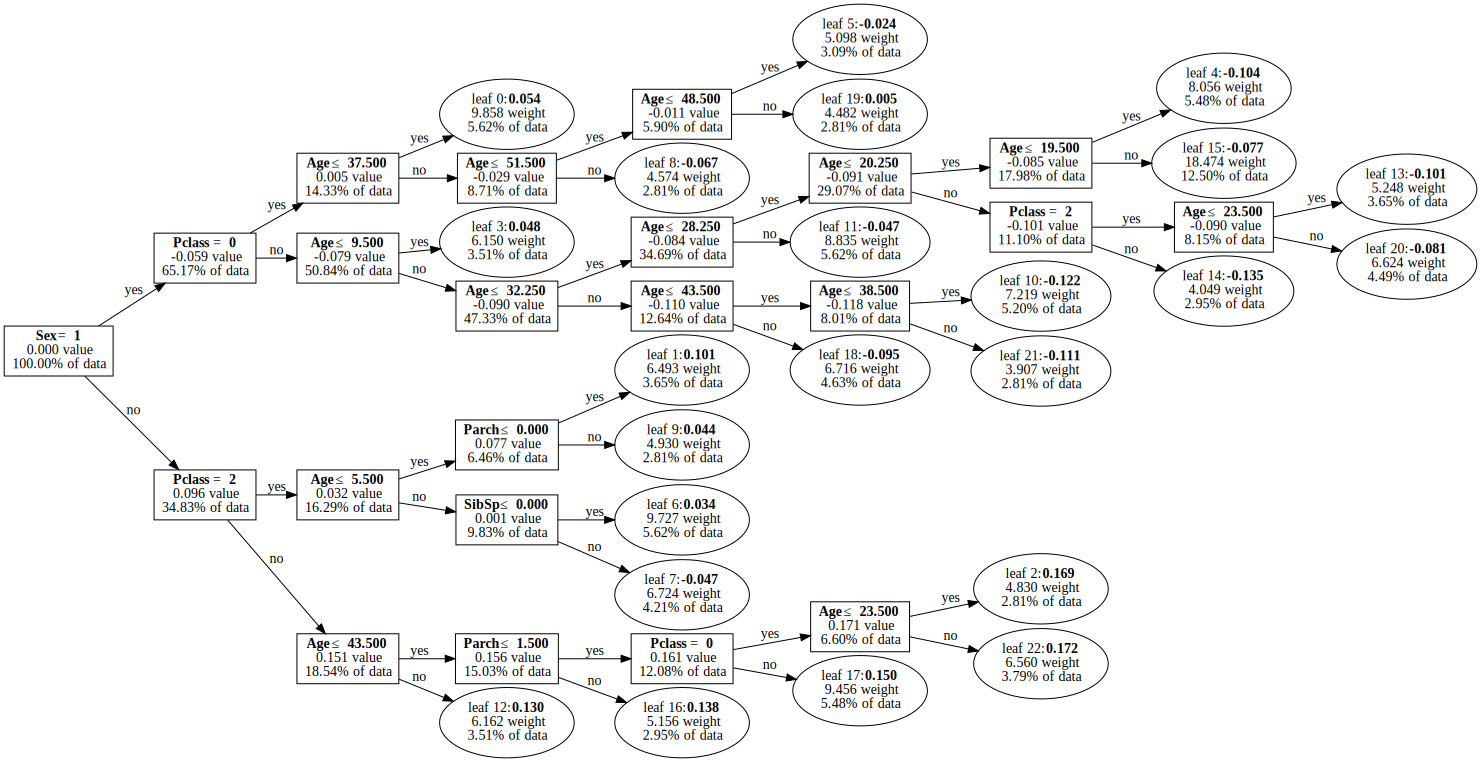

In [48]:
lgb.create_tree_digraph(clf, orientation=orientation, tree_index=4, show_info=show_info)

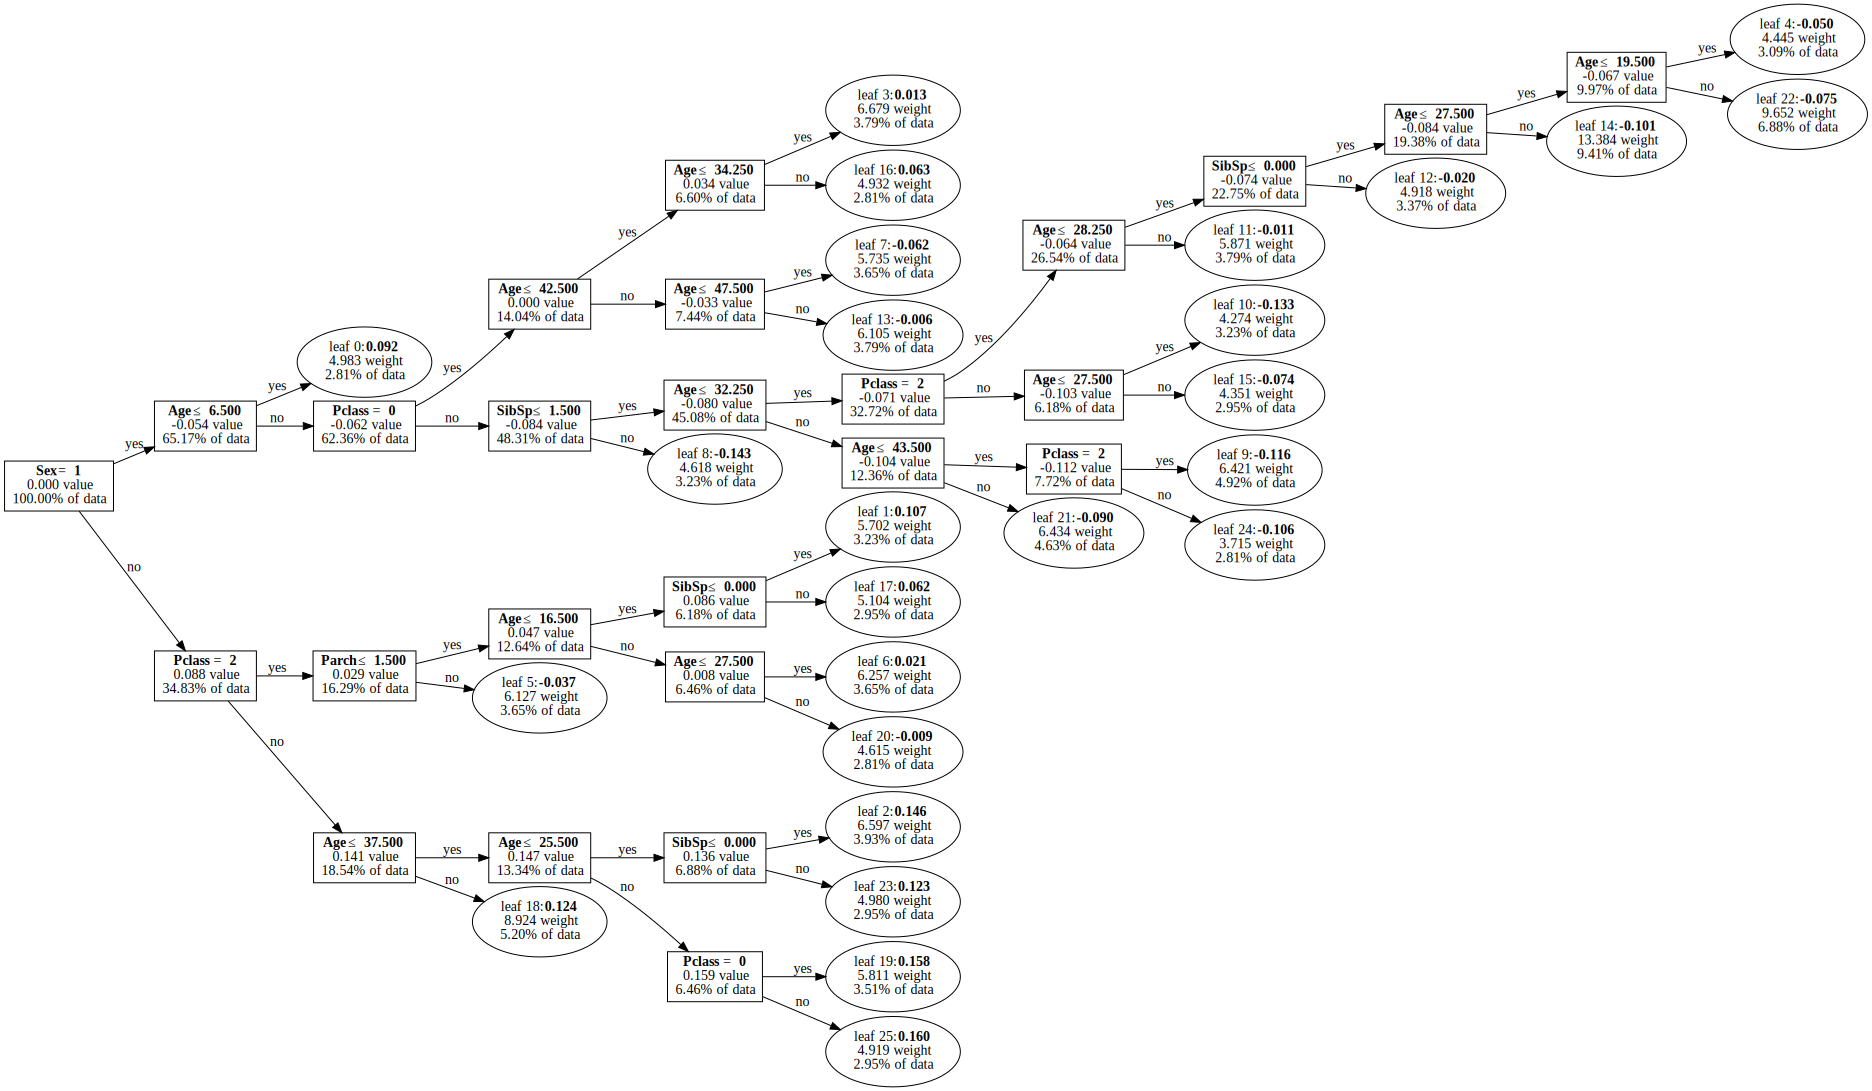

In [49]:
lgb.create_tree_digraph(clf, orientation=orientation, tree_index=5, show_info=show_info)

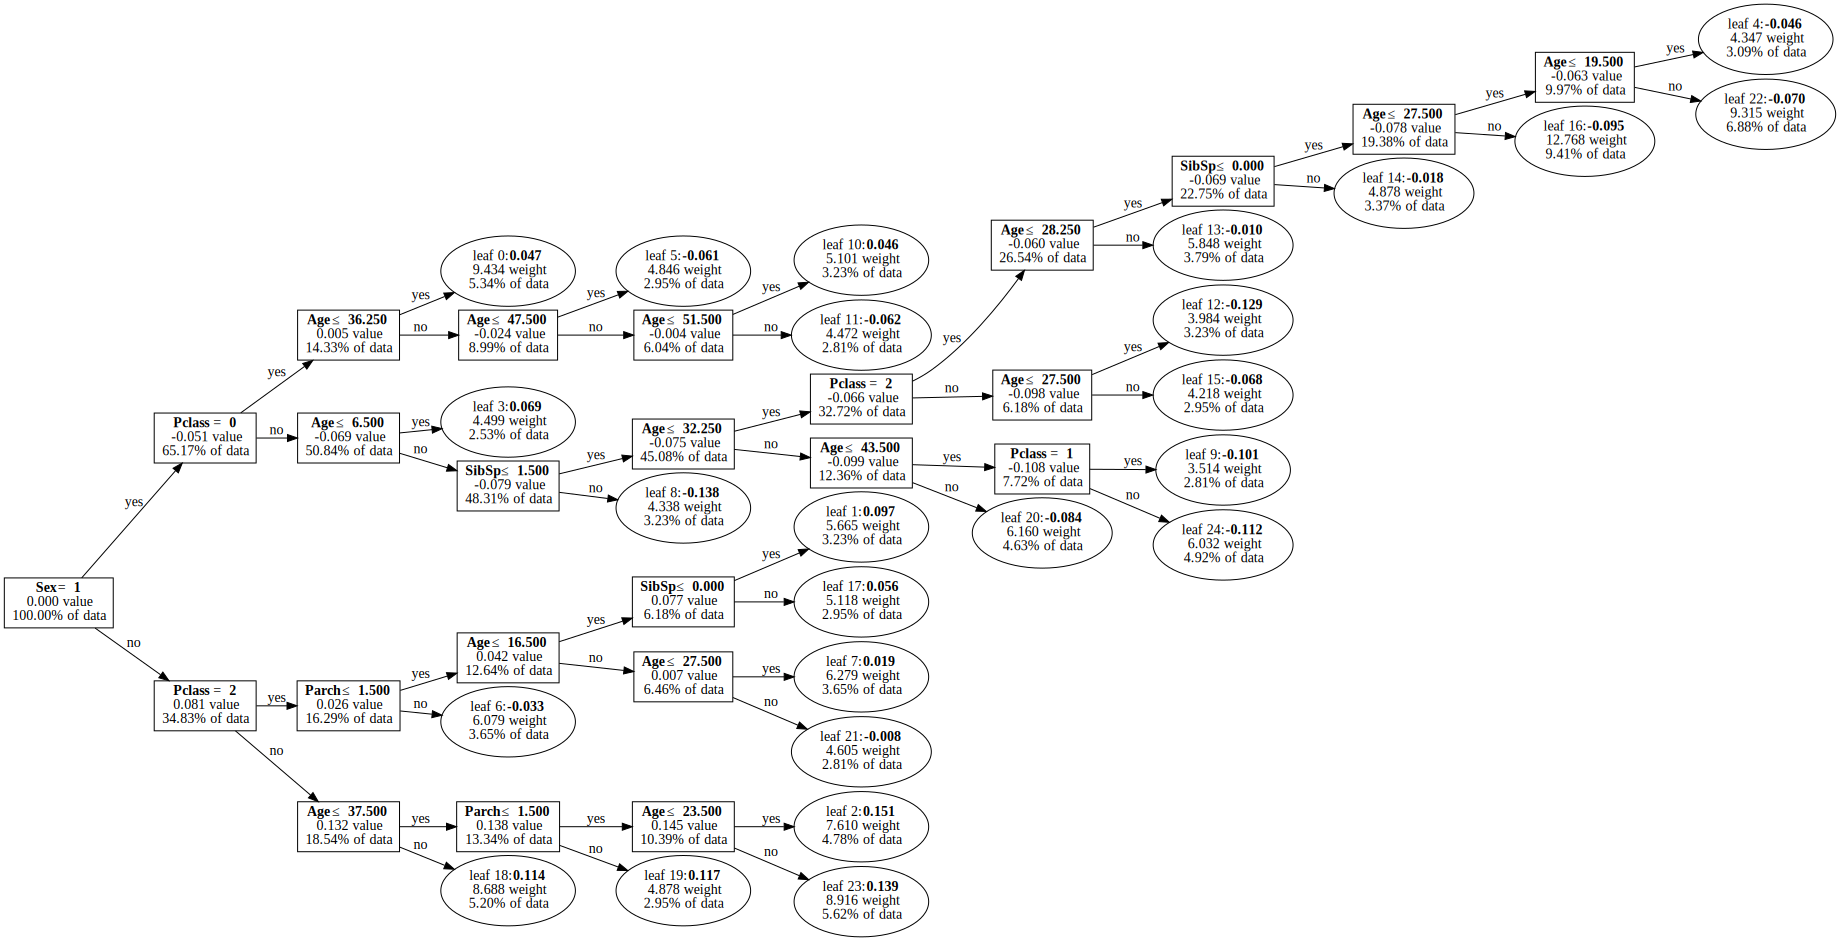

In [50]:
lgb.create_tree_digraph(clf, orientation=orientation, tree_index=6, show_info=show_info)

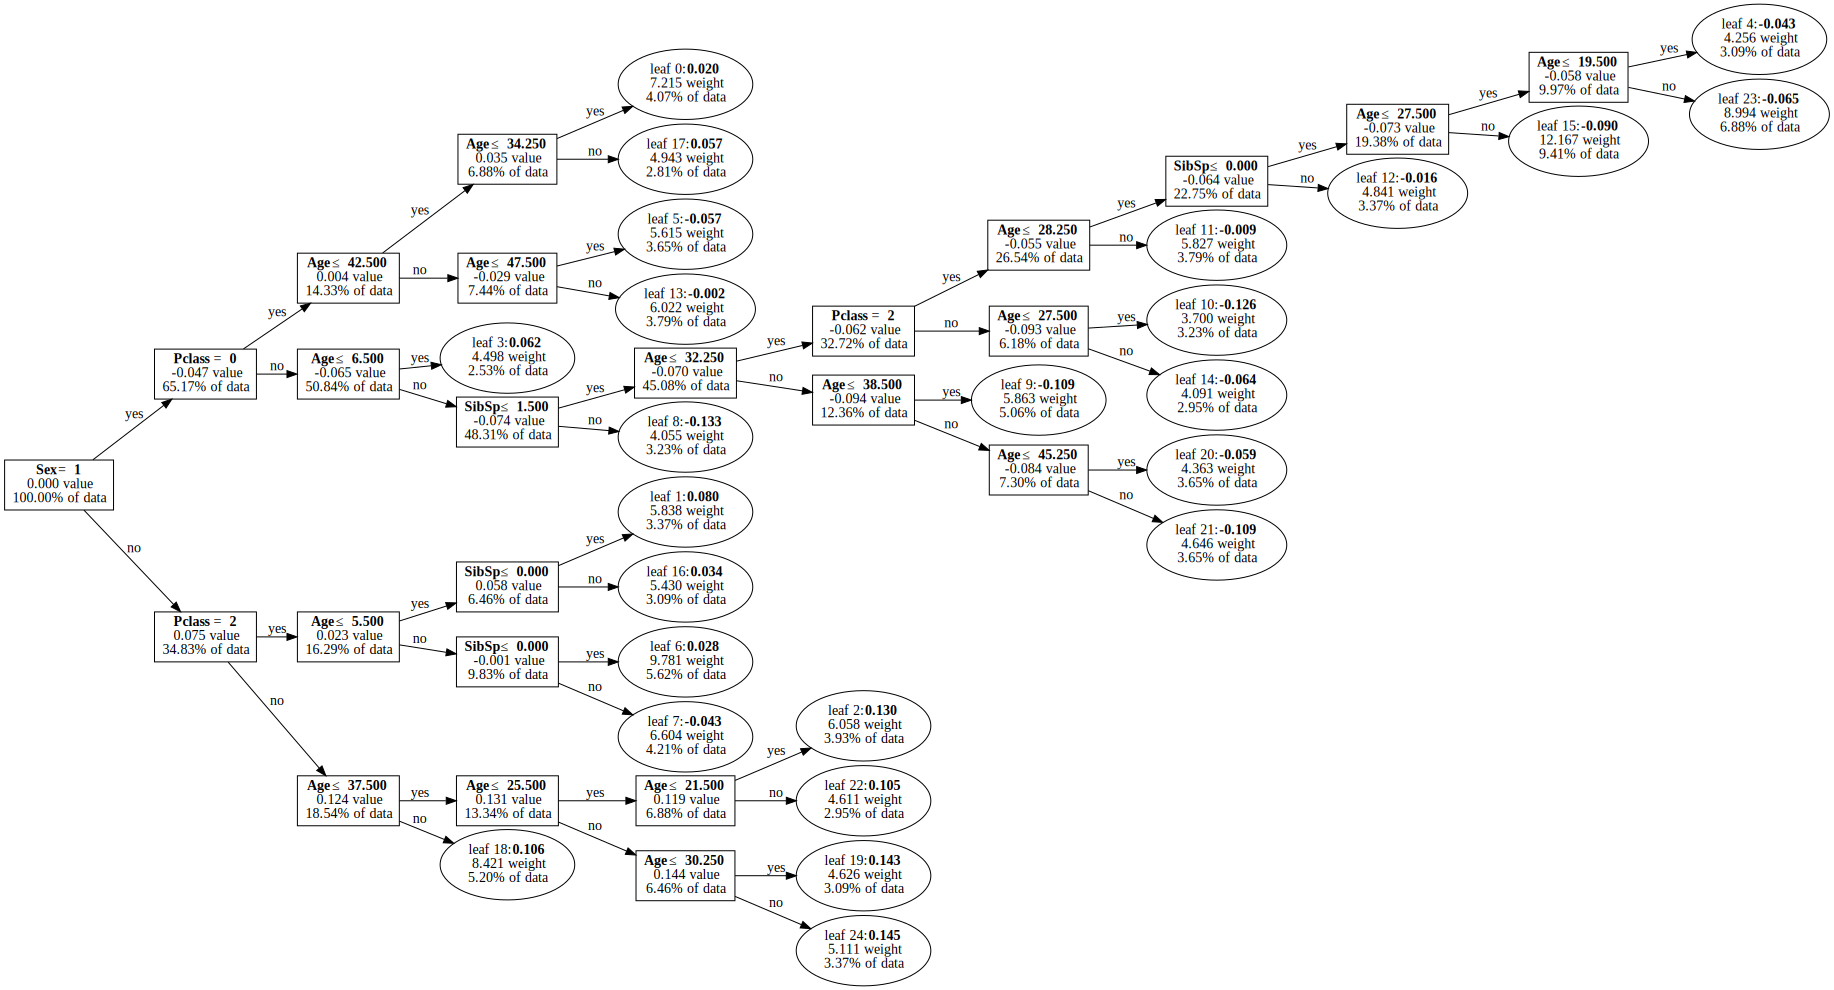

In [51]:
lgb.create_tree_digraph(clf, orientation=orientation, tree_index=7, show_info=show_info)

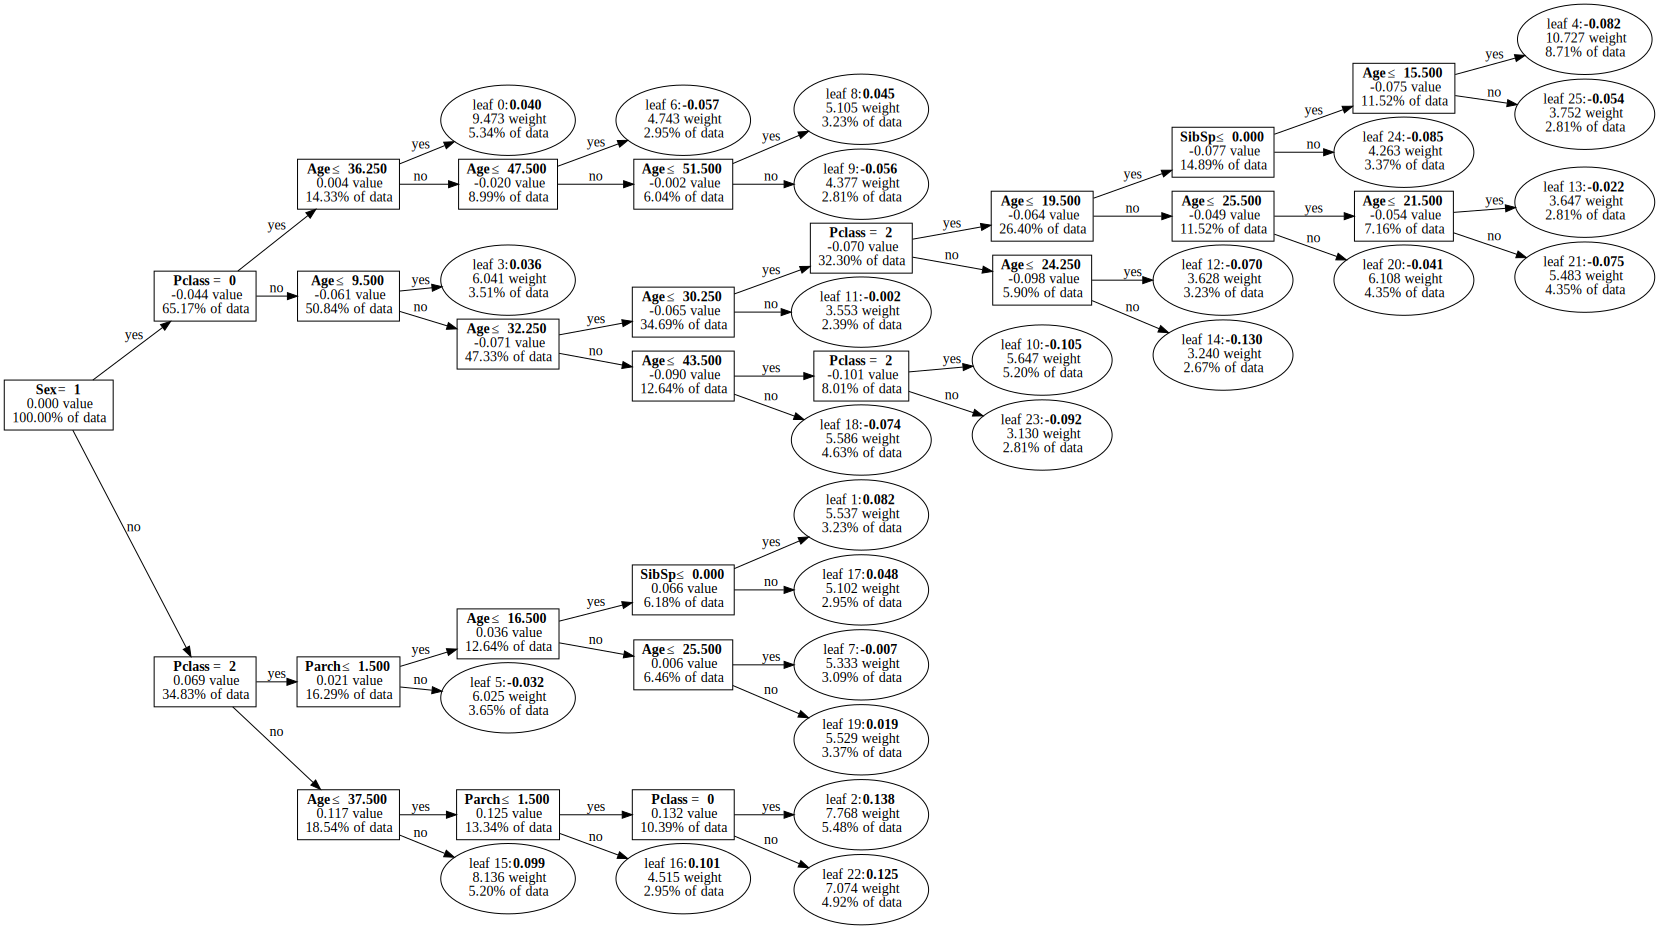

In [52]:
lgb.create_tree_digraph(clf, orientation=orientation, tree_index=8, show_info=show_info)

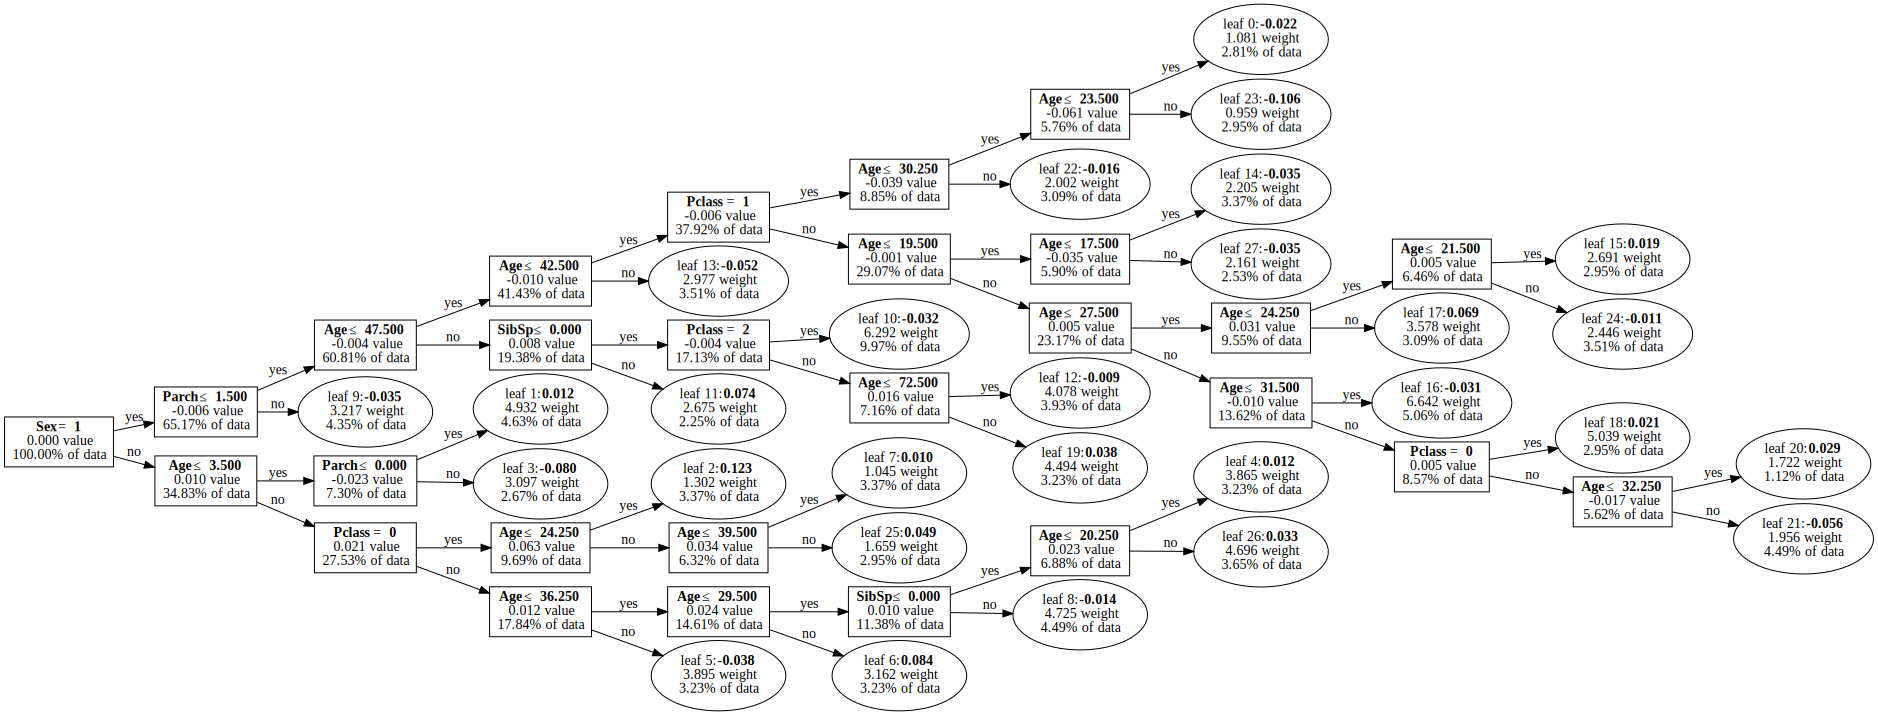

In [53]:
lgb.create_tree_digraph(clf, orientation=orientation, tree_index=34, show_info=show_info)

In [54]:
g=lgb.create_tree_digraph(clf, orientation='vertical')

# g.format='svg'
# g.format='png'
# g.format='pdf'
# g.render('tree.gv', view=True)

## SHAP

In [55]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

$$
\begin{align}
\text{odds}&=\frac{p}{1-p} \\ \\
\text{log odds or logit} (\textbf{logi}\text{stic un}\textbf{it})&=ln(\frac{p}{1-p}) \\ \\
p&=\frac{odds}{1+odds}
\end{align}
$$

$$
\begin{align}
logit&=ln(\frac{p}{1-p}) \\ \\
\text{how to inverse } logit \\ \\
ln(\frac{p}{1-p})&=ln(odds) \\ \\
\frac{p}{1-p}&=e^{ln(odds)} \\ \\
p&=(1-p)e^{ln(odds)} \\ \\
p&=e^{ln(odds)}-p\cdot e^{ln(odds)} \\ \\
p+p\cdot e^{ln(odds)}&=e^{ln(odds)} \\ \\
p(1+e^{ln(odds)})&=e^{ln(odds)} \\ \\
p&=\frac{e^{ln(odds)}}{1+e^{ln(odds)}} \\ \\
p&=\frac{1}{1+e^{-ln(odds)}} \\ \\
\end{align}
$$

Text(0, 0.5, 'ln(odds) or logit')

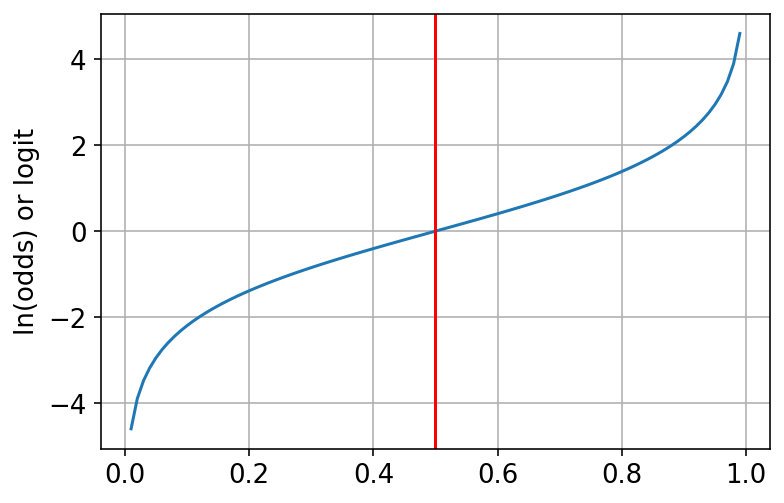

In [56]:
p=np.arange(0, 1, .01)
y=np.log(p/(1-p))

plt.plot(p, y)
plt.grid(True)
plt.axvline(.5, color='red')
plt.ylabel('ln(odds) or logit')

Text(0, 0.5, 'prob')

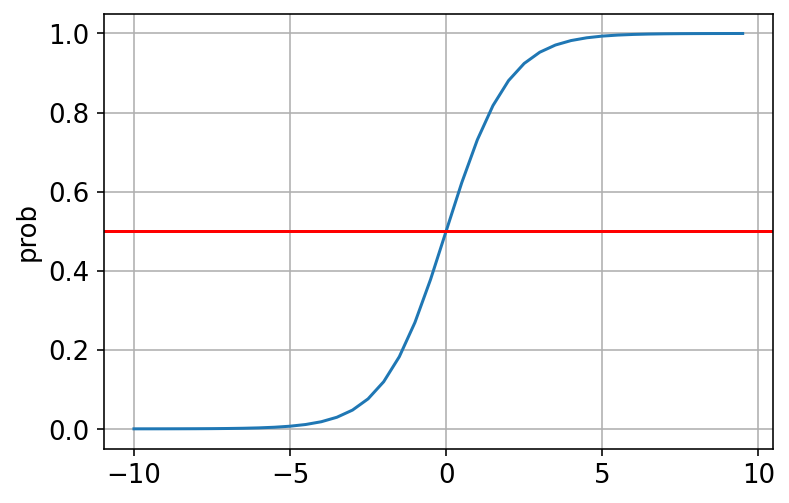

In [57]:
x=np.arange(-10, 10, .5)
y=1/(1+np.exp(-x))

plt.plot(x, y)
plt.grid(True)
plt.axhline(.5, color='red')
plt.ylabel('prob')

In [58]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def log_odds_to_prob(x):
    return 1-1/(1+np.exp(x))

def logit_to_prob(logit):
    odds=np.exp(logit)
    return odds / (1 + odds)

def odds(p):
    return p/(1-p)

def case_detail(case_data):
    '''
    format obj returned from shap.force_plot()
    '''
    de=pd.DataFrame(case_data.data['features'])
    fcols=[]
    for i in case_data.data['features'].keys():
        fcols.append(case_data.data['featureNames'][i])
    de.columns=fcols
    return de

def individual_case_plot(explainer, X, case_index, class_no=1, link='logit', verbose=False):
    """
    >>> individual_case_plot(explainer, X_train, 1)
    """
#     link='identity' # show value as log-odds
#     link='logit' # show value as prob
    shap_values = explainer.shap_values(X.iloc[[case_index]])[class_no]
    g=shap.force_plot(explainer.expected_value[class_no], shap_values=shap_values, features=X.iloc[case_index, :], link=link)
    if verbose:
        print(f'predict_proba = {clf.predict_proba(X.iloc[[case_index]])}')
        p=logit_to_prob(g.data['outValue'])
        print(f'p={p:.4f}, odds={odds(p):.2f}')
        pprint(g.__dict__)
    return g

In [59]:
len(shap_values)

2

In [60]:
shap_values[1].shape

(891, 5)

In [61]:
shap_values[0] # class = 0 (dead)

array([[ 5.01163733e-01,  7.94609746e-01,  2.53476815e-01,
        -2.86304650e-01,  8.46484648e-04],
       [-1.65702242e+00, -1.97707589e+00,  5.79648201e-01,
        -6.79817699e-02, -3.27795110e-02],
       [ 9.84557516e-01, -1.56794468e+00, -2.10973992e-01,
        -2.50855403e-01, -7.93806952e-02],
       ...,
       [ 1.17637403e+00, -1.49814409e+00, -4.34500116e-01,
        -4.19576767e-02,  2.71204395e-01],
       [-1.42138779e+00,  1.03961898e+00, -6.60641408e-01,
        -1.11959278e-01, -1.90341686e-02],
       [ 4.18514026e-01,  7.17024395e-01, -7.64339798e-01,
        -1.96025811e-01, -1.83166415e-02]])

In [62]:
shap_values[1] # class = 1 (survived)

array([[-5.01163733e-01, -7.94609746e-01, -2.53476815e-01,
         2.86304650e-01, -8.46484648e-04],
       [ 1.65702242e+00,  1.97707589e+00, -5.79648201e-01,
         6.79817699e-02,  3.27795110e-02],
       [-9.84557516e-01,  1.56794468e+00,  2.10973992e-01,
         2.50855403e-01,  7.93806952e-02],
       ...,
       [-1.17637403e+00,  1.49814409e+00,  4.34500116e-01,
         4.19576767e-02, -2.71204395e-01],
       [ 1.42138779e+00, -1.03961898e+00,  6.60641408e-01,
         1.11959278e-01,  1.90341686e-02],
       [-4.18514026e-01, -7.17024395e-01,  7.64339798e-01,
         1.96025811e-01,  1.83166415e-02]])

In [63]:
dshap=pd.DataFrame(shap_values[1], columns=feature_cols)
dshap

,Pclass,Sex,Age,SibSp,Parch
0,-0.501164,-0.794610,-0.253477,0.286305,-0.000846
1,1.657022,1.977076,-0.579648,0.067982,0.032780
2,-0.984558,1.567945,0.210974,0.250855,0.079381
3,1.706279,2.083054,0.154864,0.036898,0.054895
4,-0.743171,-1.044190,-0.560645,0.134163,0.014983
...,...,...,...,...,...
886,-0.944019,-1.440806,-0.068469,0.121775,0.006395
887,1.493579,2.361143,0.201323,0.152680,0.073369
888,-1.176374,1.498144,0.434500,0.041958,-0.271204
889,1.421388,-1.039619,0.660641,0.111959,0.019034


### feature importances

In [64]:
np.abs(dshap).mean().sort_values(ascending=False)

Sex       1.351744
Pclass    0.793083
Age       0.480388
SibSp     0.231040
Parch     0.048344
dtype: float64

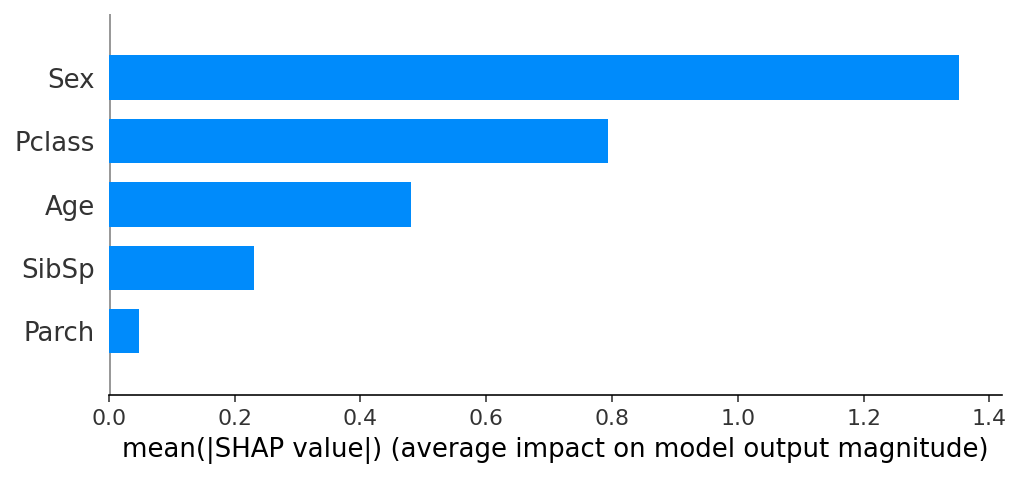

In [65]:
shap.summary_plot(shap_values[1], X, plot_type="bar")

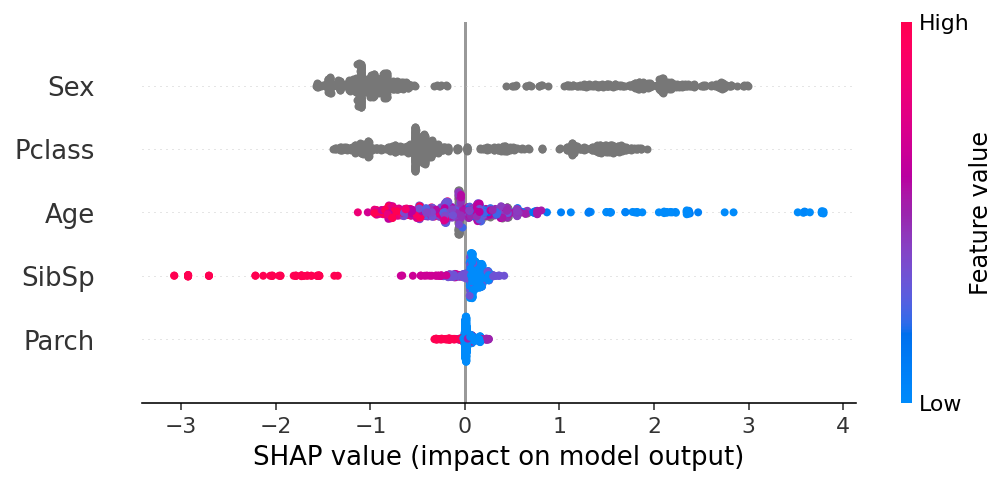

In [66]:
shap.summary_plot(shap_values[1], X)

### dependence_plot

In [67]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Pclass  891 non-null    category
 1   Sex     891 non-null    category
 2   Age     714 non-null    float64 
 3   SibSp   891 non-null    int64   
 4   Parch   891 non-null    int64   
dtypes: category(2), float64(1), int64(2)
memory usage: 23.0 KB


In [68]:
class_no=1

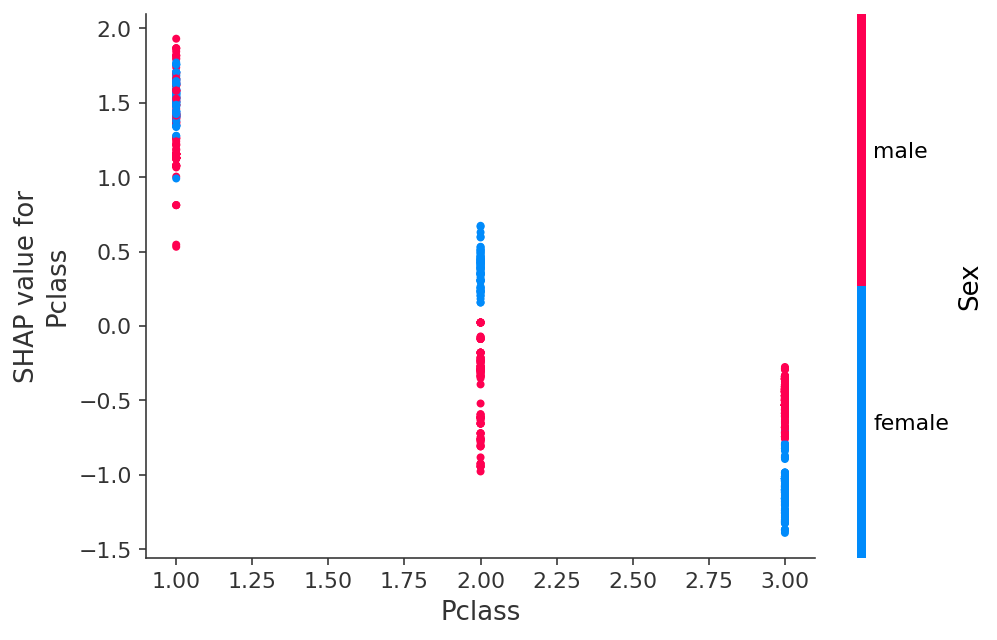

In [69]:
shap.dependence_plot('Pclass', shap_values=shap_values[class_no], features=X, interaction_index='Sex')    

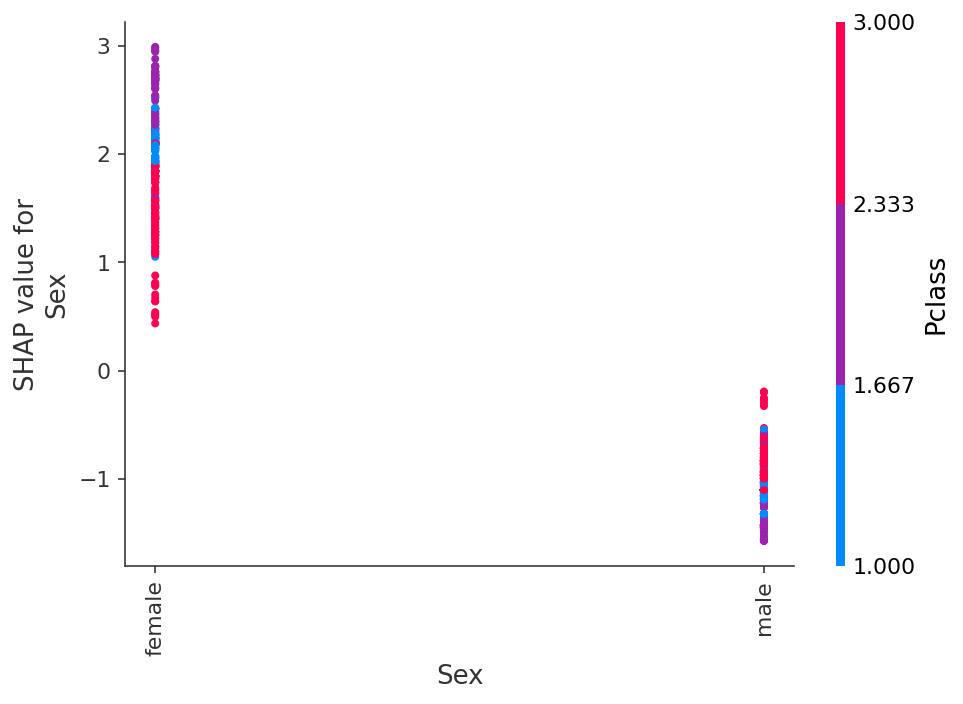

In [70]:
shap.dependence_plot('Sex', shap_values=shap_values[class_no], features=X, interaction_index='Pclass')    

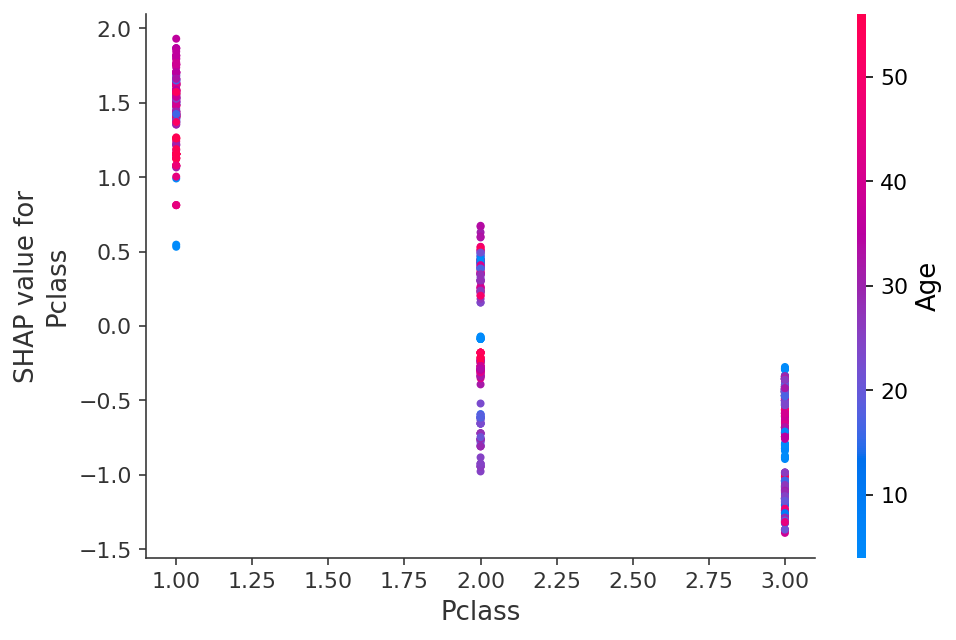

In [71]:
shap.dependence_plot('Pclass', shap_values=shap_values[class_no], features=X, interaction_index='Age')    

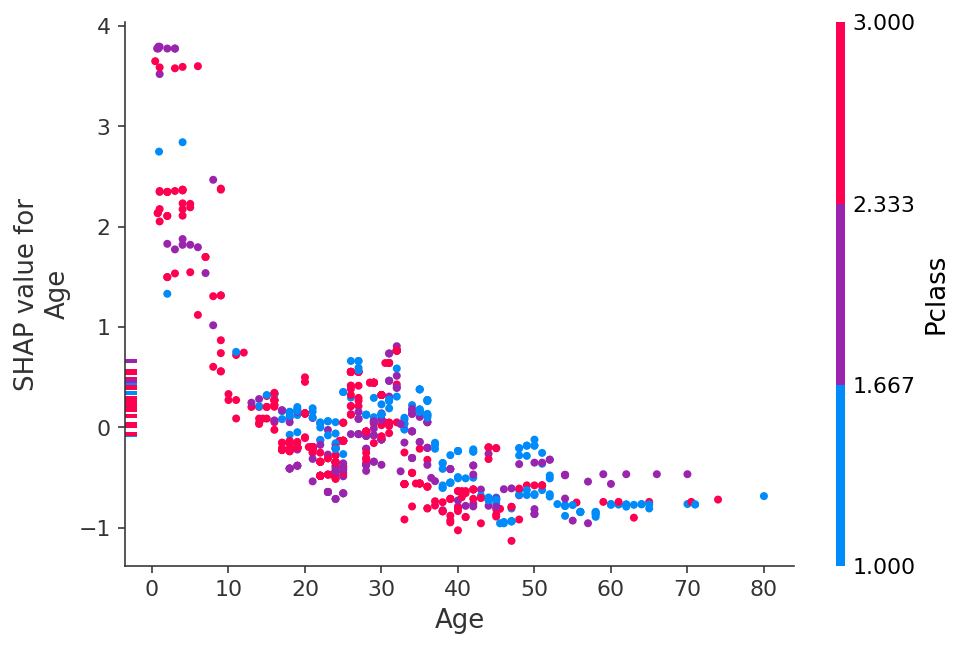

In [72]:
shap.dependence_plot('Age', shap_values=shap_values[class_no], features=X, interaction_index='Pclass')    

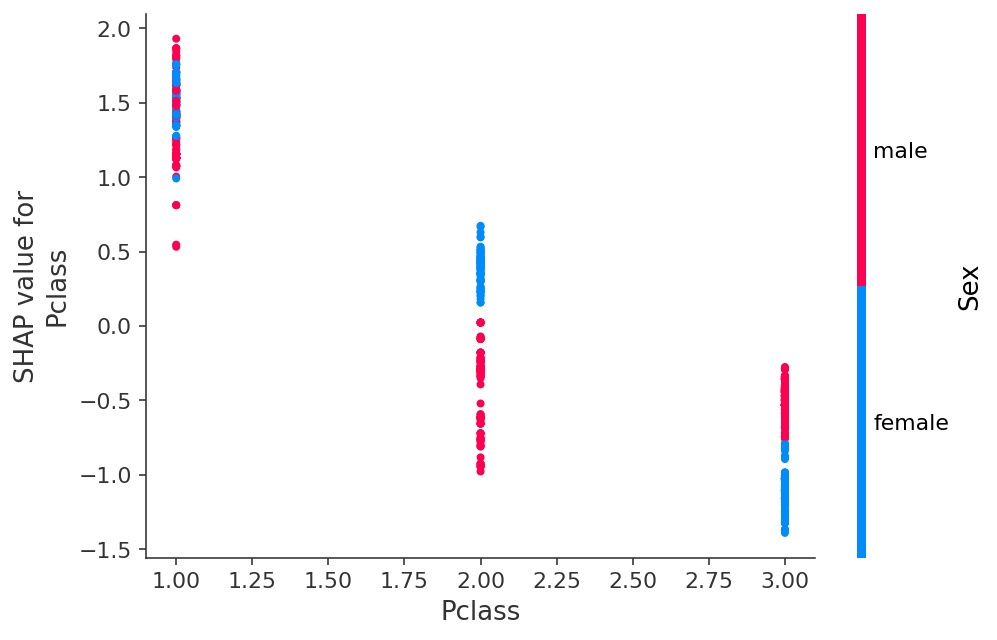

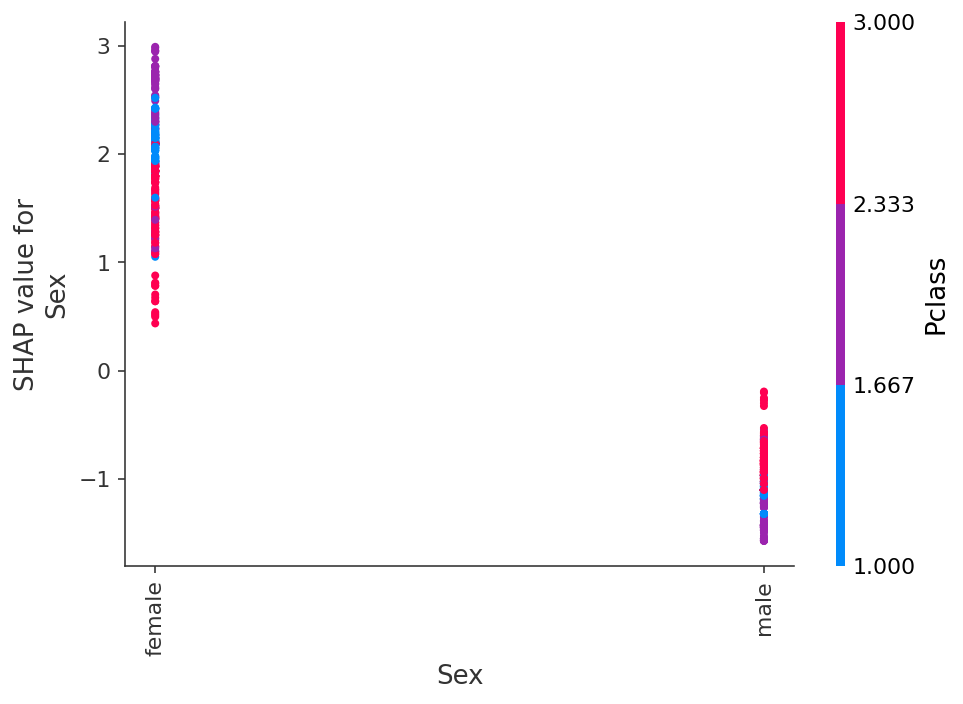

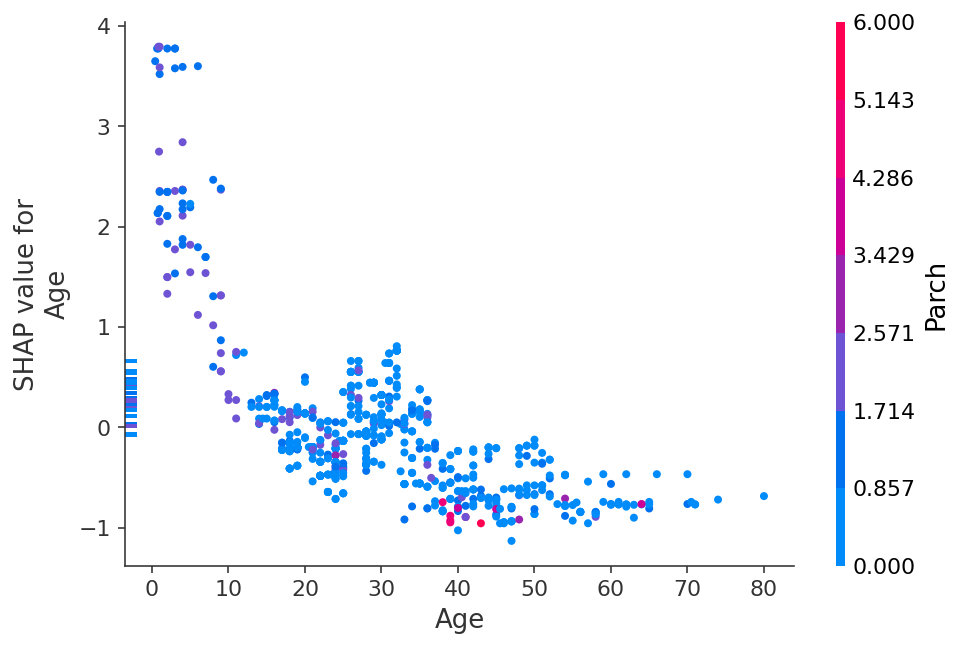

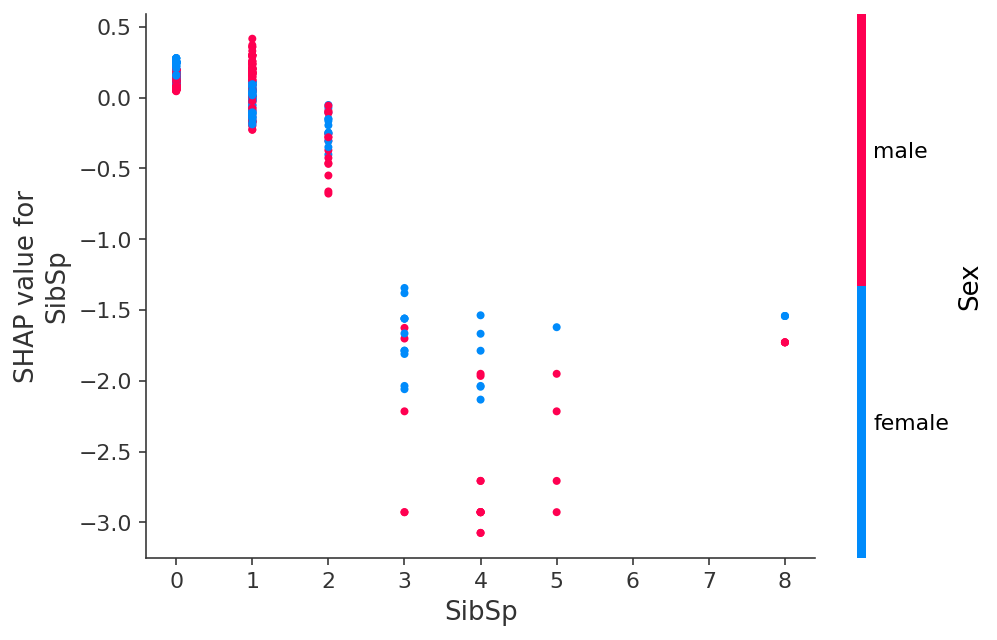

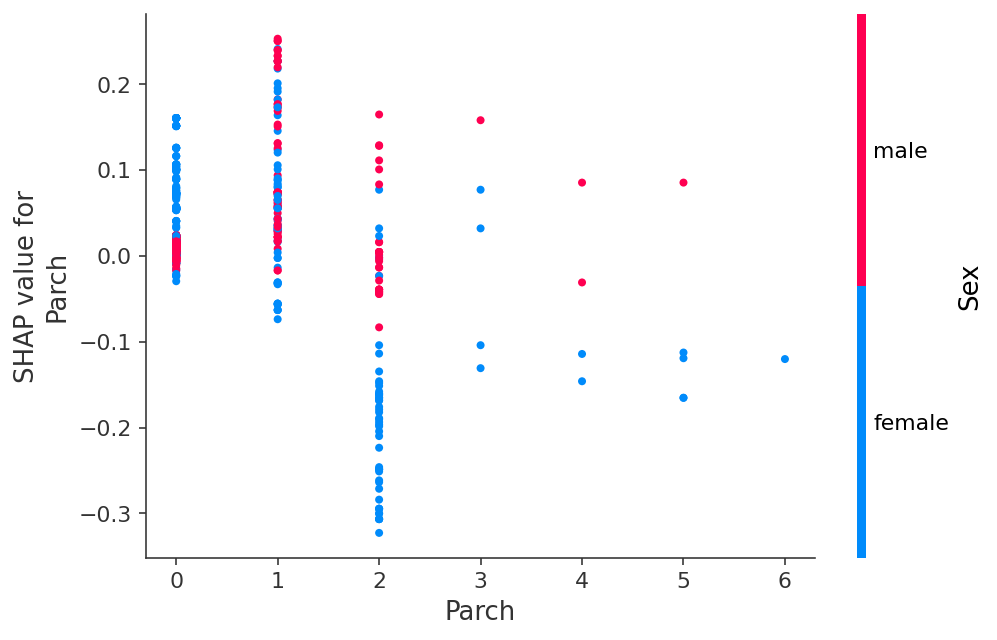

In [73]:
class_no=1
for c in feature_cols:
    shap.dependence_plot(c, shap_values=shap_values[class_no], features=X)    

### interpret case(s)

In [74]:
shap_values[1][:5]

array([[-5.01163733e-01, -7.94609746e-01, -2.53476815e-01,
         2.86304650e-01, -8.46484648e-04],
       [ 1.65702242e+00,  1.97707589e+00, -5.79648201e-01,
         6.79817699e-02,  3.27795110e-02],
       [-9.84557516e-01,  1.56794468e+00,  2.10973992e-01,
         2.50855403e-01,  7.93806952e-02],
       [ 1.70627890e+00,  2.08305429e+00,  1.54863681e-01,
         3.68976762e-02,  5.48948836e-02],
       [-7.43170719e-01, -1.04419030e+00, -5.60644593e-01,
         1.34162906e-01,  1.49830460e-02]])

In [75]:
X[:5]

,Pclass,Sex,Age,SibSp,Parch
0,3,male,22.0,1,0
1,1,female,38.0,1,0
2,3,female,26.0,0,0
3,1,female,35.0,1,0
4,3,male,35.0,0,0


In [76]:
case_index=0
X.iloc[[case_index]]

,Pclass,Sex,Age,SibSp,Parch
0,3,male,22.0,1,0


In [77]:
explainer.shap_values(X.iloc[[case_index]])[1]

array([[-0.50116373, -0.79460975, -0.25347681,  0.28630465, -0.00084648]])

In [78]:
clf.predict_proba(X[:5])

array([[0.86550262, 0.13449738],
       [0.07194175, 0.92805825],
       [0.37130471, 0.62869529],
       [0.03112827, 0.96887173],
       [0.94250446, 0.05749554]])

In [79]:
clf.predict(X[:5])

array([0, 1, 1, 1, 0], dtype=int64)

In [80]:
g=individual_case_plot(explainer, X, case_index=0, class_no=1, link='identity') # link='identity' will show log odds value
g

In [81]:
g.__dict__

{'data': {'outNames': ['f(x)'],
  'baseValue': -0.5979735844427556,
  'outValue': -1.8617657123114384,
  'link': 'identity',
  'featureNames': ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch'],
  'features': {0: {'effect': -0.5011637327377314, 'value': 3.0},
   1: {'effect': -0.7946097456064606, 'value': 'male'},
   2: {'effect': -0.2534768145678379, 'value': 22.0},
   3: {'effect': 0.2863046496908918, 'value': 1.0},
   4: {'effect': -0.000846484647544895, 'value': 0.0}},
  'plot_cmap': 'RdBu',
  'labelMargin': 20}}

In [82]:
g=individual_case_plot(explainer, X, case_index=0, class_no=1, link='logit') # link='logit' will change log-odds number into probability
g

In [83]:
g=individual_case_plot(explainer, X, case_index=0, class_no=1, link='logit', verbose=True) # link='logit' will change log-odds number into probability
g

predict_proba = [[0.86550262 0.13449738]]
p=0.1345, odds=0.16
{'data': {'baseValue': -0.5979735844427556,
          'featureNames': ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch'],
          'features': {0: {'effect': -0.5011637327377314, 'value': 3.0},
                       1: {'effect': -0.7946097456064606, 'value': 'male'},
                       2: {'effect': -0.2534768145678379, 'value': 22.0},
                       3: {'effect': 0.2863046496908918, 'value': 1.0},
                       4: {'effect': -0.000846484647544895, 'value': 0.0}},
          'link': 'logit',
          'outNames': ['f(x)'],
          'outValue': -1.8617657123114384,
          'plot_cmap': 'RdBu'}}


In [84]:
logit_to_prob(explainer.expected_value[1]) # base value

0.35480744243977624

In [85]:
p=logit_to_prob(g.data['outValue'])
print(f'p={p:.2f}, odds={odds(p):.2f}')

p=0.13, odds=0.16


In [86]:
clf.predict_proba(X.iloc[[0]])

array([[0.86550262, 0.13449738]])

In [87]:
case_index=1
g=individual_case_plot(explainer, X, case_index=case_index, class_no=1, link='logit', verbose=True)
g

predict_proba = [[0.07194175 0.92805825]]
p=0.9281, odds=12.90
{'data': {'baseValue': -0.5979735844427556,
          'featureNames': ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch'],
          'features': {0: {'effect': 1.6570224166739478, 'value': 1.0},
                       1: {'effect': 1.9770758932059396, 'value': 'female'},
                       2: {'effect': -0.579648201039771, 'value': 38.0},
                       3: {'effect': 0.0679817699136296, 'value': 1.0},
                       4: {'effect': 0.03277951103941307, 'value': 0.0}},
          'link': 'logit',
          'outNames': ['f(x)'],
          'outValue': 2.557237805350404,
          'plot_cmap': 'RdBu'}}


In [88]:
case_detail(g)

,Pclass,Sex,Age,SibSp,Parch
effect,1.657022,1.977076,-0.579648,0.067982,0.03278
value,1.000000,female,38.000000,1.000000,0.00000


In [89]:
g=individual_case_plot(explainer, X, case_index=2, class_no=1, link='logit', verbose=True)
g

predict_proba = [[0.37130471 0.62869529]]
p=0.6287, odds=1.69
{'data': {'baseValue': -0.5979735844427556,
          'featureNames': ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch'],
          'features': {0: {'effect': -0.9845575164870383, 'value': 3.0},
                       1: {'effect': 1.5679446758646869, 'value': 'female'},
                       2: {'effect': 0.21097399220284374, 'value': 26.0},
                       3: {'effect': 0.250855403151865, 'value': 0.0},
                       4: {'effect': 0.07938069520709763, 'value': 0.0}},
          'link': 'logit',
          'outNames': ['f(x)'],
          'outValue': 0.5266236654966994,
          'plot_cmap': 'RdBu'}}


In [90]:
class_no=1
shap.force_plot(explainer.expected_value[class_no], shap_values[class_no][:100], X[:100])